# Hammervariation

In [ ]:
!git clone https://github.com/ClonedPoro/HammerProjekt.git
!pip install scikit-posthocs
!pip install pingouin

Cloning into 'HammerProjekt'...
remote: Enumerating objects: 3236, done.
remote: Counting objects: 100% (708/708), done.
remote: Compressing objects: 100% (421/421), done.
remote: Total 3236 (delta 288), reused 694 (delta 284), pack-reused 2528
Receiving objects: 100% (3236/3236), 907.86 MiB | 17.47 MiB/s, done.
Resolving deltas: 100% (1523/1523), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 5.0 MB/s eta 0:00:00


**0. Nötige Packages importieren**


In [ ]:
 # import
import pandas as pd
import os
import seaborn as sb
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from posix import remove
import re
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from scikit_posthocs import posthoc_wilcoxon
from pingouin import pairwise_gameshowell
import warnings

warnings.filterwarnings("ignore")

pd.options.mode.chained_assignment = None

# Bis hier hin alles ausführen, ab hier aber bitte nichts mehr ausführen

**1. Laden der Daten**

Methode um csv Daten in das Programm zu laden. Es kommt vor dass eine nicht angezeigte Datei ".ipynb_checkpoints" detecktiert wird. Indem fall muss der Boolean "remove" auf True gesetzt werden.

In [ ]:
def load_data(path, remove, drop):
  # Liste aller Dateien im Verzeichnis
  files = os.listdir(path)
  if remove == True:
    files.remove('.ipynb_checkpoints')

  # Anzahl der Dateien im Ordner ZV (Zielscheibenvariation)
  nr_files = len(files)

  # erstellen leerer Liste
  data_list = [None] * nr_files

  # load data into lists
  for file in range(len(files)):
      data_list[file] = pd.read_csv(path + '/' + files[file], sep=";", decimal=",")

      if drop == True:
        data_list[file] = data_list[file].drop([0])

  return data_list

Laden der Treffer

In [ ]:
# HV-VR
hv_vr_raw = load_data(path = '/content/HammerProjekt/Ergebnisse/HV_VR', remove = False, drop = True)

# HV-Real
hv_real_raw = load_data(path = '/content/HammerProjekt/Ergebnisse/HV_Real', remove = False, drop = True)

merged_data_vr = pd.concat(hv_vr_raw)
merged_data_real = pd.concat(hv_real_raw)

merged_data_vr.rename(columns={' x [mm]': 'x [mm]'}, inplace = True)
merged_data_real.rename(columns={' x [mm]': 'x [mm]'}, inplace = True)

del merged_data_vr["timecode"]
del merged_data_vr["Unnamed: 10"]

merged_data_vr["mode"] = "VR"
merged_data_real["mode"] = "Real"

def map_weight(data):
  if data in ([1.0, 4.0]):
    return "leicht"
  elif data in ([2.0,  5.0]):
    return "mittel"
  elif data in ([3.0,  6.0]):
    return "schwer"

merged_data = pd.concat([merged_data_vr, merged_data_real], ignore_index=True)

merged_data["Hammer"] = merged_data["position"].apply(map_weight)

**2. Demographische Daten**

In [ ]:
demography = pd.read_csv("/content/HammerProjekt/Ergebnisse/hv_fragebogen.csv")

# Demographische Daten
print("Verteilung Geschlecht: \n", demography["Bitte geben Sie ihr Geschlecht an."].value_counts(normalize = True), "\n")

print("Mittelwert Alter: ", demography["Bitte nennen Sie ihr Alter (in Jahren)."].mean())
print("Standardabweichung Alter: ", demography["Bitte nennen Sie ihr Alter (in Jahren)."].std(), "\n")

print("Mittelwert Körpergröße: ", demography["Bitte geben Sie Ihre Größe an (in cm)."].mean())
print("Standardabweichung Körpergröße: ", demography["Bitte geben Sie Ihre Größe an (in cm)."].std(), "\n")

print("Mittelwert handwerkliche Fähigkeiten: ", demography['Wie schätzen Sie Ihre handwerklichen Fähigkeiten ein?\nMeine handwerklichen Fähigkeiten sind ...'].mean())
print("Standardabweichung handwerkliche Fähigkeiten: ", demography['Wie schätzen Sie Ihre handwerklichen Fähigkeiten ein?\nMeine handwerklichen Fähigkeiten sind ...'].std(), "\n")

print("\n \n \n")

replacer_technikaffinitaet = {"stimmt gar nicht": 1, "stimmt weitgehend nicht": 2, "stimmt eher nicht": 3, "stimmt eher": 4, "stimmt weitgehend": 5, "stimmt völlig": 6}

replacer_cybersickness = {"gar nicht": 1, "leicht": 2, "mäßig": 3, "stark": 4}

# Subsets für die einzelnen Fragebögen bilden
technikaffinitaet = demography.loc[:, 'Bitte geben Sie den Grad Ihrer Zustimmung zu folgenden Aussagen an. [Ich beschäftige mich gern genauer mit technischen Systemen.]':'Bitte geben Sie den Grad Ihrer Zustimmung zu folgenden Aussagen an. [Ich versuche, die Möglichkeiten eines technischen Systems vollständig auszunutzen.]'].replace(replacer_technikaffinitaet)
presence = demography.loc[:, "Auf einer Skala von 1-10 wie sehr fühlten Sie sich in der Anwendung präsent, als wären sie wirklich dort?"]
cybersickness = demography.loc[:, "Dieser Fragebogen beinhaltet eine Liste von Symptomen, die nach dem Benutzen eines Head-Mounts-Displays auftreten können. Bitte geben Sie für jedes Symptom an, wie stark es jetzt gerade bei Ihnen auftritt. [Allgemeines Unwohlsein]":'Dieser Fragebogen beinhaltet eine Liste von Symptomen, die nach dem Benutzen eines Head-Mounts-Displays auftreten können. Bitte geben Sie für jedes Symptom an, wie stark es jetzt gerade bei Ihnen auftritt. [Kopfdruck]'].replace(replacer_cybersickness)

# Fragebogen zur Technikaffinität
for question in technikaffinitaet:
  print(technikaffinitaet[question].describe(), "\n")

print("\n \n \n")

# Frage zur Presence
print(presence.describe(), "\n")

print("\n \n \n")

# Fragebogen zur Cybersickness
for question in cybersickness:
  print(cybersickness[question].describe(), "\n")

Verteilung Geschlecht: 
 männlich    0.545455
weiblich    0.454545
Name: Bitte geben Sie ihr Geschlecht an., dtype: float64 

Mittelwert Alter:  22.393939393939394
Standardabweichung Alter:  2.7606542922307606 

Mittelwert Körpergröße:  175.06060606060606
Standardabweichung Körpergröße:  8.799642726907276 

Mittelwert handwerkliche Fähigkeiten:  3.121212121212121
Standardabweichung handwerkliche Fähigkeiten:  1.082750425928563 


 
 

count    33.000000
mean      3.393939
std       1.197377
min       1.000000
25%       3.000000
50%       3.000000
75%       4.000000
max       6.000000
Name: Bitte geben Sie den Grad Ihrer Zustimmung zu folgenden Aussagen an. [Ich beschäftige mich gern genauer mit technischen Systemen.], dtype: float64 

count    33.000000
mean      3.939394
std       1.456438
min       1.000000
25%       3.000000
50%       4.000000
75%       5.000000
max       6.000000
Name: Bitte geben Sie den Grad Ihrer Zustimmung zu folgenden Aussagen an. [Ich probiere gern die Funkti

**3. Analyse der Treffer in den Umgebungen der Zielscheibenvariation**


Plot der Verteilung von X gegen y der Treffer in VR

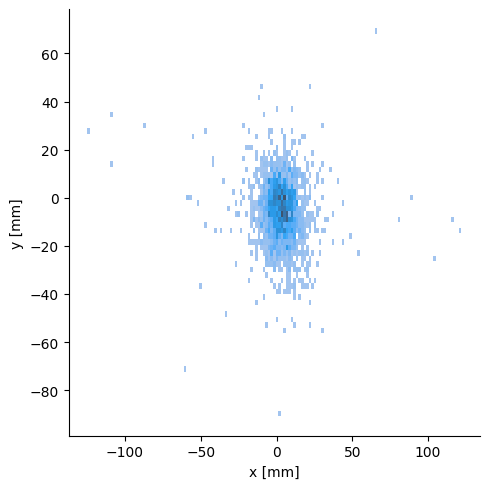

In [ ]:
#distribution plot with color-coding
sb.displot(data=merged_data_vr, x="x [mm]", y="y [mm]", legend=True)

Ausgeben der eschreibenden Werte für x [mm]

In [ ]:
print("Descriptive values for x [mm]:\n", merged_data_vr.iloc[:,6].describe(), "\n")

Descriptive values for x [mm]:
 count    2036.000000
mean        3.225655
std        12.223981
min      -124.913400
25%        -1.905616
50%         3.377934
75%         8.784483
max       121.941400
Name: x [mm], dtype: float64 



Ausgeben der beschreibenden Werte für y [mm]

In [ ]:
print("Descriptive values for y [mm]:\n", merged_data_vr.iloc[:,7].describe(), "\n")

Descriptive values for y [mm]:
 count    2036.000000
mean       -5.410921
std        12.411328
min       -90.883320
25%       -12.609852
50%        -4.915458
75%         2.140362
max        70.431250
Name: y [mm], dtype: float64 



Ausgeben der beschreibenden Werte für die Distanz des Treffers zum Mittelpunkt (0,0) in mm

In [ ]:
print("Descriptive values for distance [mm]:\n", merged_data_vr.iloc[:,8].describe())

Descriptive values for distance [mm]:
 count    2036.000000
mean       14.407388
std        11.640204
min         0.270052
25%         7.403804
50%        11.809380
75%        18.361577
max       128.028800
Name: distance [mm], dtype: float64


Histogramm der Verteilung der X-Koordinate der Treffer

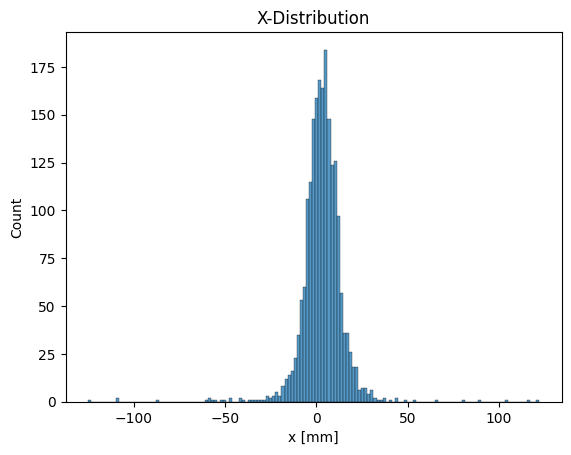

In [ ]:
sb.histplot(data=merged_data_vr, x="x [mm]")
plt.title("X-Distribution")
plt.show()

Boxplot der verteilten Daten

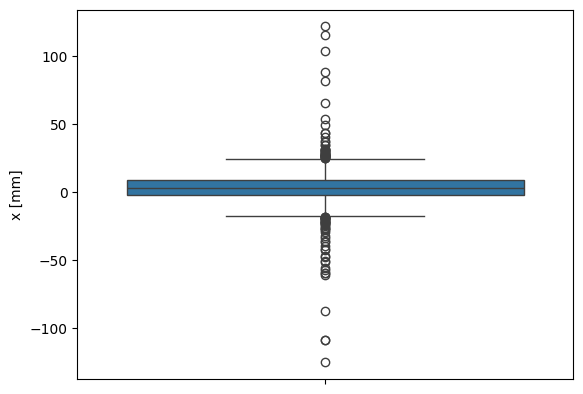

In [ ]:
plt.clf()
sb.boxplot(merged_data_vr['x [mm]'])
plt.show()

Histogramm der Verteilung der Y-Koordinate der Treffer

Text(0.5, 1.0, 'Y-Distribution')

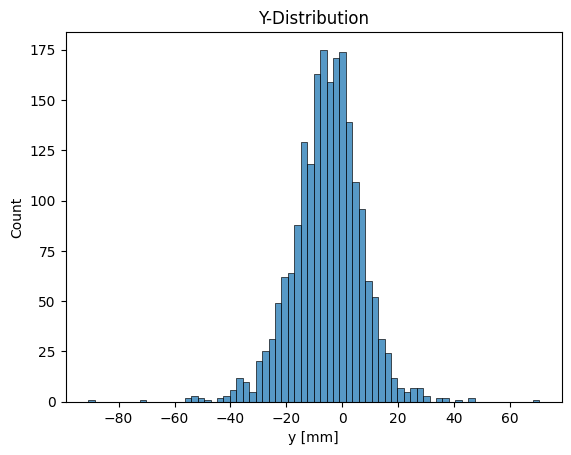

In [ ]:
sb.histplot(data=merged_data_vr, x="y [mm]")
plt.title("Y-Distribution")

Boxplot der verteilten Daten

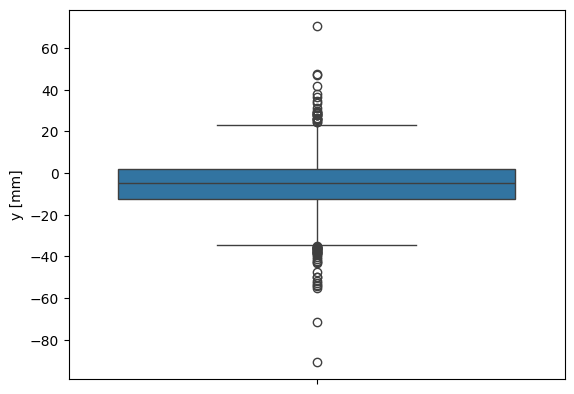

In [ ]:
plt.clf()
sb.boxplot(merged_data_vr['y [mm]'])
plt.show()

Shapiro-Wilk Test für die X-Koordinaten der Treffer

In [ ]:
print("Shapiro-Wilk Test for x-values: ", stats.shapiro(merged_data_vr.iloc[:,6]))

Shapiro-Wilk Test for x-values:  ShapiroResult(statistic=0.7831006050109863, pvalue=1.401298464324817e-45)


Shapiro-Wilk Test für die Y-Koordinaten der Treffer

In [ ]:
print("Shapiro-Wilk Test for y-values: ", stats.shapiro(merged_data_vr.iloc[:,7]))

Shapiro-Wilk Test for y-values:  ShapiroResult(statistic=0.9743993282318115, pvalue=1.2807442151360134e-18)


Levene-Test für x-y-Wert-Varianzen

In [ ]:
print("Levene Test for x-y-value variances: ", stats.levene(merged_data_vr.iloc[:,6], merged_data_vr.iloc[:,7]))

Levene Test for x-y-value variances:  LeveneResult(statistic=41.74742087313378, pvalue=1.1609570089681099e-10)


**3. Analyse der Teffer in der realen Umgebung aus der Studie der verschiedenen Zielscheibenpositionen**

Laden der VR-Treffer

Plot der Verteilung von X gegen Y der Treffer in Real

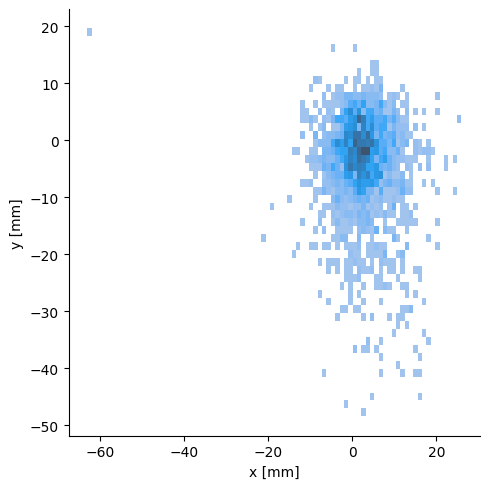

In [ ]:
#distribution plot with color-coding
sb.displot(data=merged_data_real, x = "x [mm]", y="y [mm]", legend=True)

Ausgeben der beschreibenden Werte für x [mm]

In [ ]:
print("Descriptive values for x [mm]:\n", merged_data_real.iloc[:,4].describe(), "\n")

Descriptive values for x [mm]:
 count    1960.000000
mean        2.577714
std         5.769989
min       -63.000000
25%        -0.735000
50%         2.240000
75%         5.740000
max        25.900000
Name: x [mm], dtype: float64 



Ausgeben der beschreibenden Werte für y [mm]

In [ ]:
print("Descriptive values for y [mm]:\n", merged_data_real.iloc[:,5].describe(), "\n")

Descriptive values for y [mm]:
 count    1960.000000
mean       -3.978714
std         8.533521
min       -48.440000
25%        -7.280000
50%        -2.380000
75%         1.540000
max        19.600000
Name: y [mm], dtype: float64 



Ausgeben der beschreibenden Werte für die Distanz des Treffers zum Mittelpunkt (0,0) in mm

In [ ]:
print("Descriptive values for distance [mm]:\n", merged_data_real.iloc[:,6].describe())

Descriptive values for distance [mm]:
 count    1960.000000
mean        8.860910
std         7.074194
min         0.197990
25%         4.211651
50%         7.084885
75%        10.998690
max        65.978481
Name: distance [mm], dtype: float64


Histogramm der Verteilung der X-Koordinate der Treffer

Text(0.5, 1.0, 'X-Distribution')

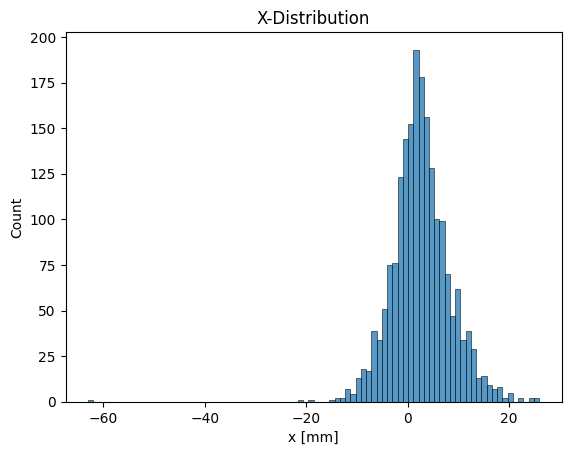

In [ ]:
sb.histplot(data=merged_data_real, x= "x [mm]")
plt.title("X-Distribution")

Boxplot der x-Verteilung der realen Daten

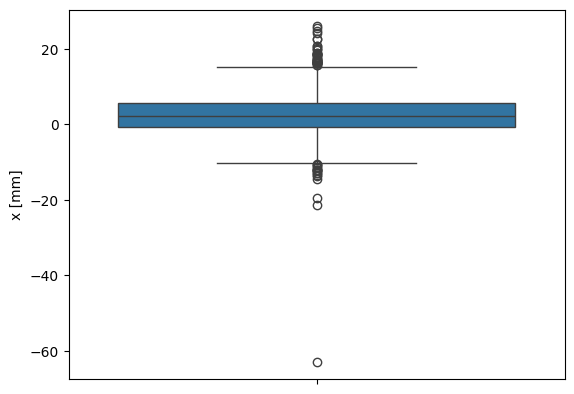

In [ ]:
plt.clf()
sb.boxplot(merged_data_real['x [mm]'])
plt.show()

Histogramm der Verteilung der Y-Koordinate der Treffer

Text(0.5, 1.0, 'Y-Distribution')

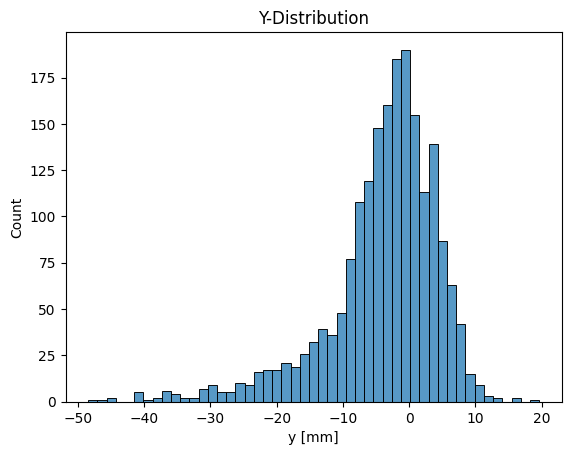

In [ ]:
sb.histplot(data=merged_data_real, x="y [mm]")
plt.title("Y-Distribution")

Boxplot der y-Werte der verteilten Daten

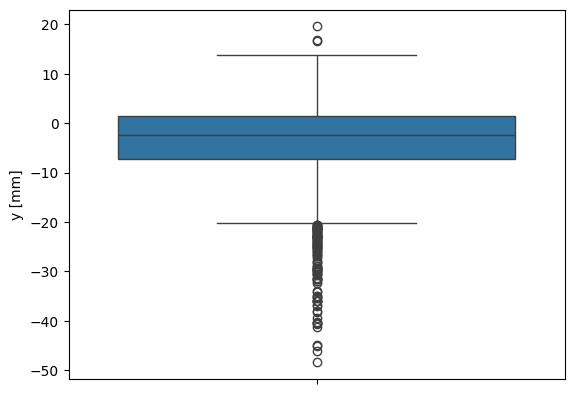

In [ ]:
plt.clf()
sb.boxplot(merged_data_real['y [mm]'])
plt.show()

Shapiro-Wilk Test für die X-Koordinaten der Treffer

In [ ]:
print("Shapiro-Wilk Test for x-values: ", stats.shapiro(merged_data_real.iloc[:,4]))

Shapiro-Wilk Test for x-values:  ShapiroResult(statistic=0.9568185210227966, pvalue=1.1620201968387763e-23)


Shapiro-Wilk Test für die Y-Koordinaten der Treffer

In [ ]:
print("Shapiro-Wilk Test for y-values: ", stats.shapiro(merged_data_real.iloc[:,5]))

Shapiro-Wilk Test for y-values:  ShapiroResult(statistic=0.900205135345459, pvalue=6.150693834618481e-34)


Levene-Test für x-y-Wert-Varianzen

In [ ]:
print("Levene Test for x-y-value variances: ", stats.levene(merged_data_real.iloc[:,4], merged_data_real.iloc[:,5]))

Levene Test for x-y-value variances:  LeveneResult(statistic=113.00353777755511, pvalue=4.859417654823617e-26)


Schiefe und Kurtosis

In [ ]:
print("Schiefe und Kurtosis Rohdaten")
print("Schiefe x VR: ", stats.skew(merged_data_vr["x [mm]"]))
print("Kurtosis x VR: ", stats.kurtosis(merged_data_vr["x [mm]"]))
print("Schiefe y VR: ", stats.skew(merged_data_vr["y [mm]"]))
print("Kurtosis y VR: ", stats.kurtosis(merged_data_vr["y [mm]"]), "\n")

print("Schiefe x real: ", stats.skew(merged_data_real["x [mm]"]))
print("Kurtosis x real: ", stats.kurtosis(merged_data_real["x [mm]"]))
print("Schiefe y real: ", stats.skew(merged_data_real["y [mm]"]))
print("Kurtosis y real: ", stats.kurtosis(merged_data_real["y [mm]"]), "\n")

print("Ganzer Datensatz:")
print("Schiefe x: ", stats.skew(merged_data["x [mm]"]))
print("Kurtosis x: ", stats.kurtosis(merged_data["x [mm]"]))
print("Schiefe y: ", stats.skew(merged_data["y [mm]"]))
print("Kurtosis y: ", stats.kurtosis(merged_data["y [mm]"]), "\n")

Schiefe und Kurtosis Rohdaten
Schiefe x VR:  -0.487443028371421
Kurtosis x VR:  27.75924521130848
Schiefe y VR:  -0.26900651968955097
Kurtosis y VR:  3.0591843575388236 

Schiefe x real:  -0.4730502221610801
Kurtosis x real:  9.051013357705957
Schiefe y real:  -1.4727044482730371
Kurtosis y real:  3.368241003787177 

Ganzer Datensatz:
Schiefe x:  -0.4960421298902441
Kurtosis x:  38.54779974495904
Schiefe y:  -0.6495908031526418
Kurtosis y:  3.8080449650511996 



-> Schiefe ist einigermaßen ok, Kurtosis ist jedoch zum Teil viel zu hoch!


**4. Versuche zur Herstellung einer Normalverteilung und Varianzgleichheit**

Hilfsfunktionen definieren

In [ ]:
def remove_outliers(col, two_sd=False, based_on_z_values=True):
    if based_on_z_values:
      z = np.abs(stats.zscore(col))
      idx_outliers = (np.where(z>3, True, False) if two_sd==False else np.where(z>2, True, False))
      return pd.Series(idx_outliers, index=col.index)
    else:
    # Wir entfernen Ausreißer auf Basis der Entfernung:
      idx_outliers = np.where(np.abs(col)>70, True, False)
      return pd.Series(idx_outliers, index=col.index)


def plot_data(data, histplot=True, distance=False):
    plt.close()
    fig, axs = plt.subplots(2, 2)
    if distance:
      labels = ["Rohe Distanzwerte VR", "Bearbeitete Distanzwerte VR", "Rohe Distanzwerte Real", "Bearbeitete Distanzwerte Real"]
    else:
      labels = ["Rohe x-Werte", "Bearbeitete x-Werte", "Rohe y-Werte", "Bearbeitete y-Werte"]


    if histplot:
      sb.histplot(data[0], ax=axs[0, 0])
      axs[0, 0].title.set_text(labels[0])

      sb.histplot(data[1], ax=axs[0, 1])
      axs[0, 1].title.set_text(labels[1])

      sb.histplot(data[2], ax=axs[1, 0])
      axs[1, 0].title.set_text(labels[2])

      sb.histplot(data[3], ax=axs[1, 1])
      axs[1, 1].title.set_text(labels[3])
    else:
      sm.qqplot(data[0], ax=axs[0, 0], line ='s')
      axs[0, 0].title.set_text(labels[0])

      sm.qqplot(data[1], ax=axs[0, 1], line ='s')
      axs[0, 1].title.set_text(labels[1])

      sm.qqplot(data[2], ax=axs[1, 0], line ='s')
      axs[1, 0].title.set_text(labels[2])

      sm.qqplot(data[3], ax=axs[1, 1], line ='s')
      axs[1, 1].title.set_text(labels[3])

    plt.tight_layout()
    plt.show()
    print("\n")

Ausreißer entfernen

In [ ]:
out_real_x = remove_outliers(merged_data_real['x [mm]'])
out_real_y = remove_outliers(merged_data_real['y [mm]'])
out_vr_x = remove_outliers(merged_data_vr['x [mm]'])
out_vr_y = remove_outliers(merged_data_vr['y [mm]'])


filtered_real_x = merged_data_real['x [mm]'].where(out_real_x == False).dropna()
filtered_real_y = merged_data_real['y [mm]'].where(out_real_y == False).dropna()
filtered_vr_x = merged_data_vr['x [mm]'].where(out_vr_x == False).dropna()
filtered_vr_y = merged_data_vr['y [mm]'].where(out_vr_y == False).dropna()

print("Anzahl Ausreißer VR x:", merged_data_vr["x [mm]"].count() - filtered_vr_x.count())
print("Anzahl Ausreißer VR y:", merged_data_vr["y [mm]"].count() - filtered_vr_y.count())
print("Anzahl Ausreißer Real x:", merged_data_real["x [mm]"].count() - filtered_real_x.count())
print("Anzahl Ausreißer Real y:", merged_data_real["y [mm]"].count() - filtered_real_y.count())

Anzahl Ausreißer VR x: 30
Anzahl Ausreißer VR y: 19
Anzahl Ausreißer Real x: 12
Anzahl Ausreißer Real y: 38


VR:


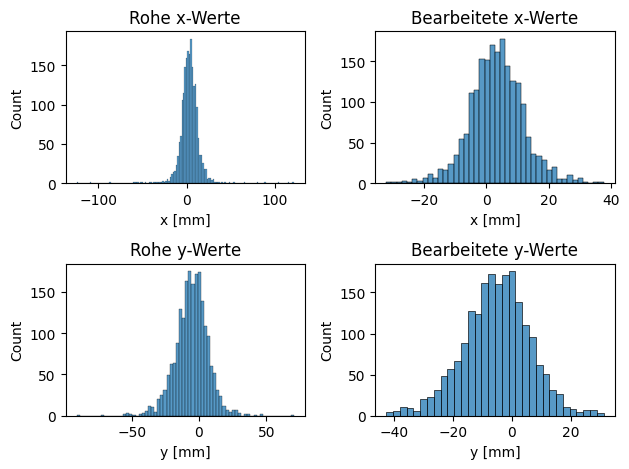

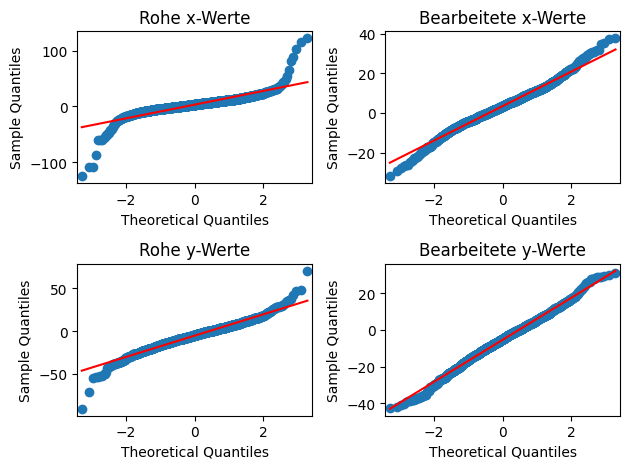



Real:


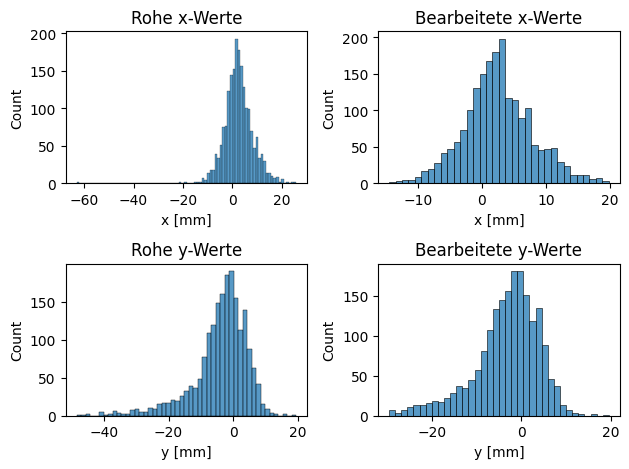

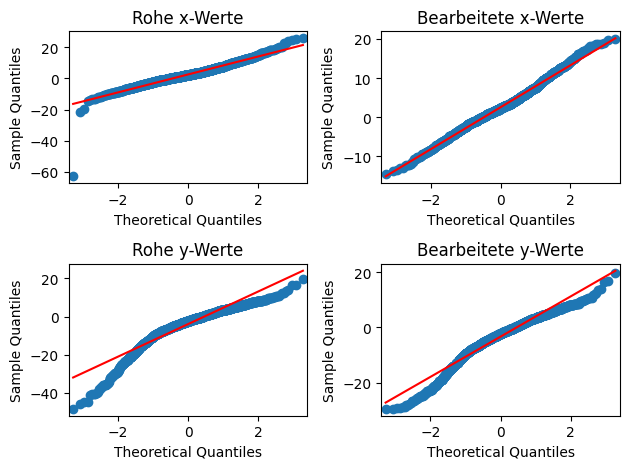

In [ ]:
print("VR:")
plot_data([merged_data_vr["x [mm]"], filtered_vr_x,
           merged_data_vr["y [mm]"], filtered_vr_y])

plot_data([merged_data_vr["x [mm]"], filtered_vr_x,
           merged_data_vr["y [mm]"], filtered_vr_y], histplot=False)

print("Real:")
plot_data([merged_data_real["x [mm]"], filtered_real_x,
           merged_data_real["y [mm]"], filtered_real_y])

plot_data([merged_data_real["x [mm]"], filtered_real_x,
           merged_data_real["y [mm]"], filtered_real_y], histplot=False)

In [ ]:
print("Shapiro-Test VR x ohne Ausreißer: ", stats.shapiro(filtered_vr_x))
print("Shapiro-Test VR y ohne Ausreißer: ", stats.shapiro(filtered_vr_y))
print("Levene-Test VR x-y ohne Ausreißer: ", stats.levene(filtered_vr_x, filtered_vr_y), "\n")

print("Shapiro-Test Real x ohne Ausreißer: ", stats.shapiro(filtered_real_x))
print("Shapiro-Test Real y ohne Ausreißer: ", stats.shapiro(filtered_real_y))
print("Levene-Test Real x-y ohne Ausreißer: ", stats.levene(filtered_real_x, filtered_real_y), "\n")

print("Schiefe und Kurtosis Ausreißer herausgefiltert")
print("Schiefe x VR: ", stats.skew(filtered_vr_x))
print("Kurtosis x VR: ", stats.kurtosis(filtered_vr_x))
print("Schiefe y VR: ", stats.skew(filtered_vr_y))
print("Kurtosis y VR: ", stats.kurtosis(filtered_vr_y), "\n")

print("Schiefe x real: ", stats.skew(filtered_real_x))
print("Kurtosis x real: ", stats.kurtosis(filtered_real_x))
print("Schiefe y real: ", stats.skew(filtered_real_y))
print("Kurtosis y real: ", stats.kurtosis(filtered_real_y), "\n")

Shapiro-Test VR x ohne Ausreißer:  ShapiroResult(statistic=0.989483118057251, pvalue=6.50797193912922e-11)
Shapiro-Test VR y ohne Ausreißer:  ShapiroResult(statistic=0.995479166507721, pvalue=8.829737453197595e-06)
Levene-Test VR x-y ohne Ausreißer:  LeveneResult(statistic=129.8748814605118, pvalue=1.2378702215278914e-29) 

Shapiro-Test Real x ohne Ausreißer:  ShapiroResult(statistic=0.9934151768684387, pvalue=1.219209053715531e-07)
Shapiro-Test Real y ohne Ausreißer:  ShapiroResult(statistic=0.952402651309967, pvalue=1.6062792654643163e-24)
Levene-Test Real x-y ohne Ausreißer:  LeveneResult(statistic=97.8074657598074, pvalue=8.575865280619418e-23) 

Schiefe und Kurtosis Ausreißer herausgefiltert
Schiefe x VR:  0.03529500596324028
Kurtosis x VR:  1.1443105344312654
Schiefe y VR:  -0.1494837732712848
Kurtosis y VR:  0.37345898718518944 

Schiefe x real:  0.18581179332582073
Kurtosis x real:  0.3722555855399623
Schiefe y real:  -0.8877420004433227
Kurtosis y real:  1.0602480274211716 



Distanz anschauen:

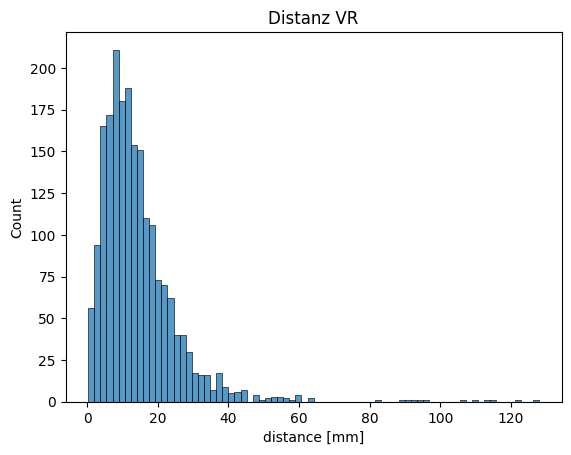

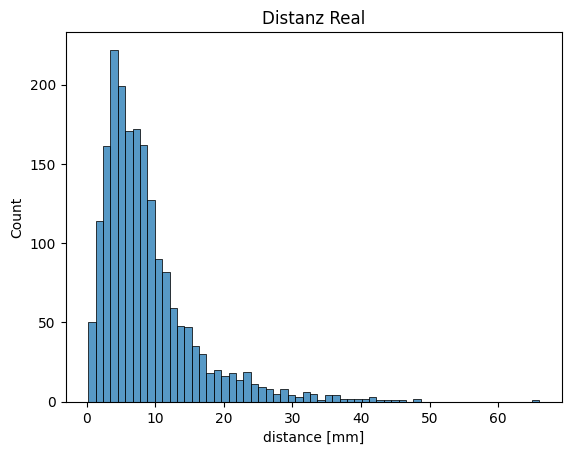

In [ ]:
plt.clf()
sb.histplot(merged_data_vr, x = "distance [mm]")
plt.title("Distanz VR")
plt.show()

plt.clf()

sb.histplot(data=merged_data_real, x= "distance [mm]")
plt.title("Distanz Real")
plt.show()

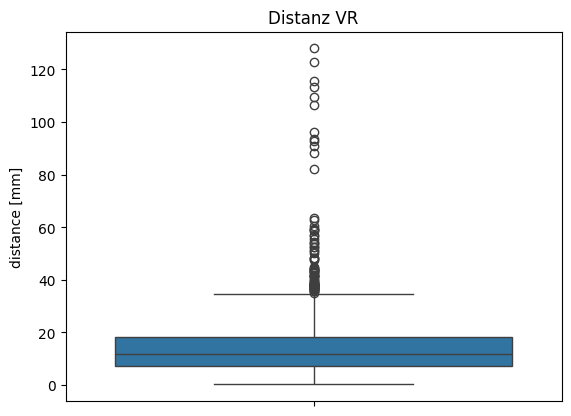

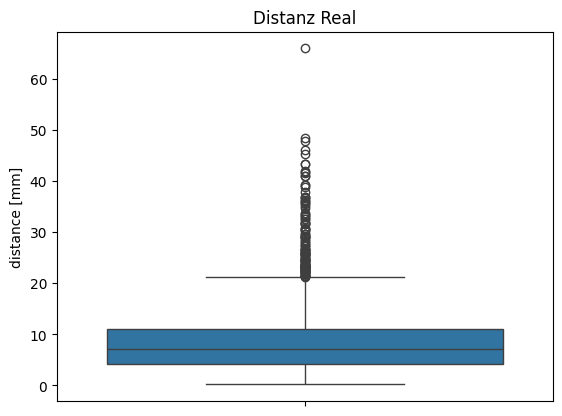

In [ ]:
plt.clf()
sb.boxplot(merged_data_vr["distance [mm]"])
plt.title("Distanz VR")
plt.show()

plt.clf()

sb.boxplot(data=merged_data_real["distance [mm]"])
plt.title("Distanz Real")
plt.show()

Anzahl Ausreißer VR:  30
Anzahl Ausreißer Real:  43 



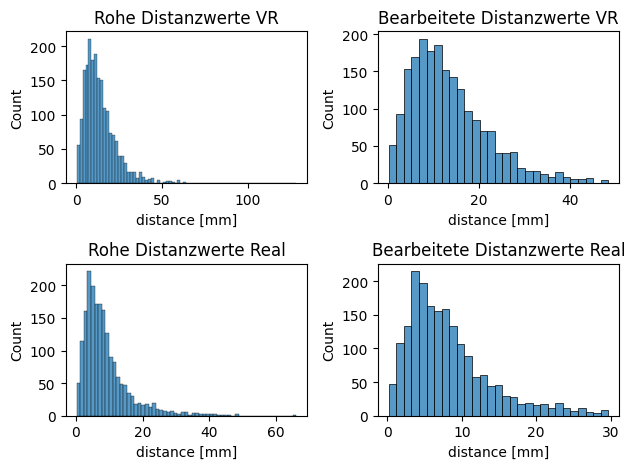



VR: 


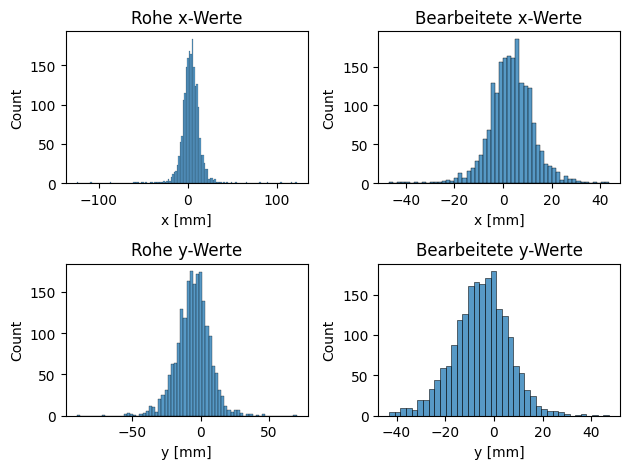

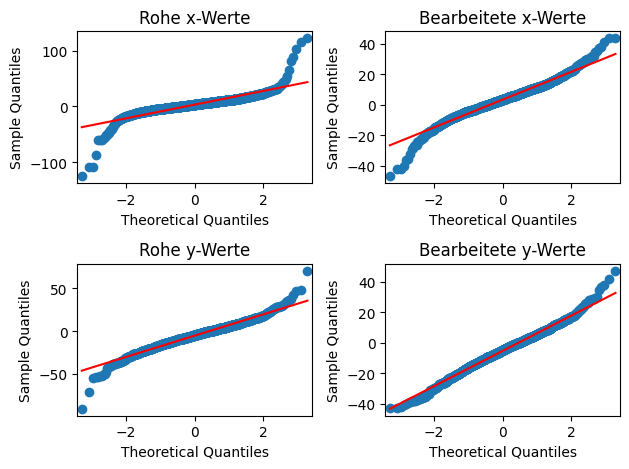



Real: 


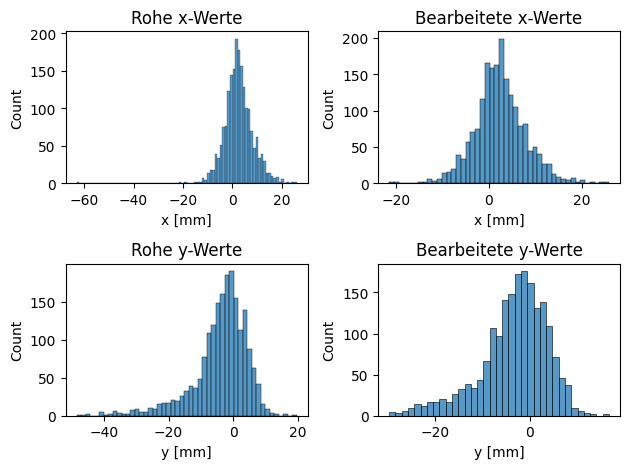

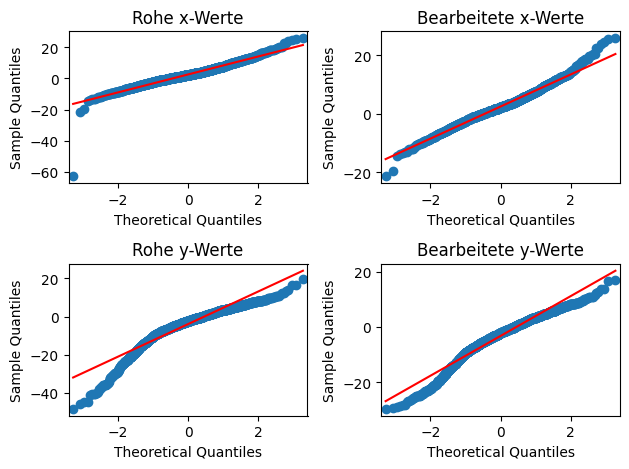

In [ ]:
out_vr_distance = remove_outliers(merged_data_vr["distance [mm]"])
out_real_distance = remove_outliers(merged_data_real["distance [mm]"])

filtered_vr_distance = merged_data_vr["distance [mm]"].where(out_vr_distance == False).dropna()
filtered_real_distance = merged_data_real["distance [mm]"].where(out_real_distance == False).dropna()

print("Anzahl Ausreißer VR: ", merged_data_vr["distance [mm]"].count() - filtered_vr_distance.count())
print("Anzahl Ausreißer Real: ", merged_data_real["distance [mm]"].count() - filtered_real_distance.count(), "\n")

plot_data([merged_data_vr["distance [mm]"], filtered_vr_distance,
           merged_data_real["distance [mm]"], filtered_real_distance], distance=True)

filtered_vr = merged_data_vr.where(out_vr_distance == False).dropna()
filtered_real = merged_data_real.where(out_real_distance == False).dropna()

print("VR: ")
plot_data([merged_data_vr["x [mm]"], filtered_vr["x [mm]"],
           merged_data_vr["y [mm]"], filtered_vr["y [mm]"]])

plot_data([merged_data_vr["x [mm]"], filtered_vr["x [mm]"],
           merged_data_vr["y [mm]"], filtered_vr["y [mm]"]], histplot=False)

print("Real: ")
plot_data([merged_data_real["x [mm]"], filtered_real["x [mm]"],
           merged_data_real["y [mm]"], filtered_real["y [mm]"]])

plot_data([merged_data_real["x [mm]"], filtered_real["x [mm]"],
           merged_data_real["y [mm]"], filtered_real["y [mm]"]], histplot=False)

In [ ]:
print("Shapiro-Test VR x ohne Distanz-Ausreißer: ", stats.shapiro(filtered_vr["x [mm]"]))
print("Shapiro-Test VR y ohne Distanz-Ausreißer: ", stats.shapiro(filtered_vr["y [mm]"]))
print("Levene-Test VR x-y ohne Distanz-Ausreißer: ", stats.levene(filtered_vr["x [mm]"], filtered_vr["y [mm]"]), "\n")

print("Shapiro-Test Real x ohne Distanz-Ausreißer: ", stats.shapiro(filtered_real["x [mm]"]))
print("Shapiro-Test Real y ohne Distanz-Ausreißer: ", stats.shapiro(filtered_real["y [mm]"]))
print("Levene-Test Real x-y ohne Distanz-Ausreißer: ", stats.levene(filtered_real["x [mm]"], filtered_real["y [mm]"]), "\n")

print("Schiefe und Kurtosis Distanz-Ausreißer herausgefiltert")
print("Schiefe x VR: ", stats.skew(filtered_vr["x [mm]"]))
print("Kurtosis x VR: ", stats.kurtosis(filtered_vr["x [mm]"]))
print("Schiefe y VR: ", stats.skew(filtered_vr["y [mm]"]))
print("Kurtosis y VR: ", stats.kurtosis(filtered_vr["y [mm]"]), "\n")

print("Schiefe x real: ", stats.skew(filtered_real["x [mm]"]))
print("Kurtosis x real: ", stats.kurtosis(filtered_real["x [mm]"]))
print("Schiefe y real: ", stats.skew(filtered_real["y [mm]"]))
print("Kurtosis y real: ", stats.kurtosis(filtered_real["y [mm]"]), "\n")

Shapiro-Test VR x ohne Distanz-Ausreißer:  ShapiroResult(statistic=0.9738325476646423, pvalue=1.1054668146851348e-18)
Shapiro-Test VR y ohne Distanz-Ausreißer:  ShapiroResult(statistic=0.9937731623649597, pvalue=1.7563482401783403e-07)
Levene-Test VR x-y ohne Distanz-Ausreißer:  LeveneResult(statistic=108.7531281682934, pvalue=3.843384890027075e-25) 

Shapiro-Test Real x ohne Distanz-Ausreißer:  ShapiroResult(statistic=0.9876207709312439, pvalue=8.748228703947536e-12)
Shapiro-Test Real y ohne Distanz-Ausreißer:  ShapiroResult(statistic=0.9542198181152344, pvalue=4.727511270787899e-24)
Levene-Test Real x-y ohne Distanz-Ausreißer:  LeveneResult(statistic=85.4734712265744, pvalue=3.797416913668714e-20) 

Schiefe und Kurtosis Distanz-Ausreißer herausgefiltert
Schiefe x VR:  -0.1809330898845933
Kurtosis x VR:  2.6035067672941823
Schiefe y VR:  -0.06214343317214084
Kurtosis y VR:  0.715739263530768 

Schiefe x real:  0.2720409901200155
Kurtosis x real:  1.156619483181113
Schiefe y real:  -0.

Kompletter Datensatz Ausreißer entfernen auf Basis der Distanz:

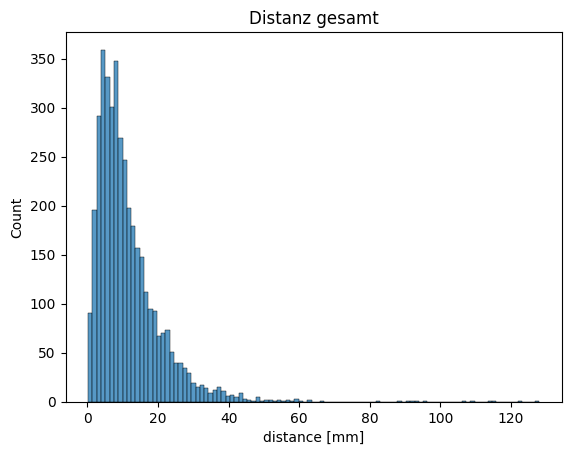

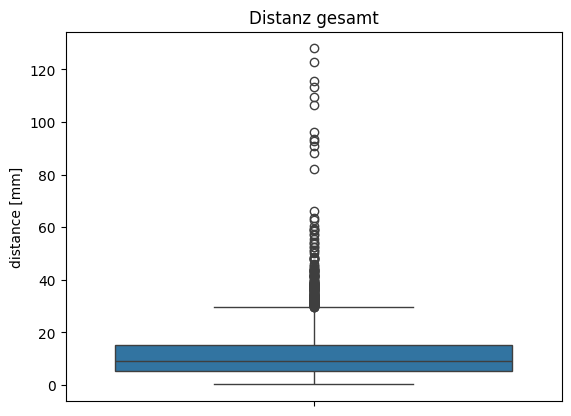



Anzahl Ausreißer gesamt:  54




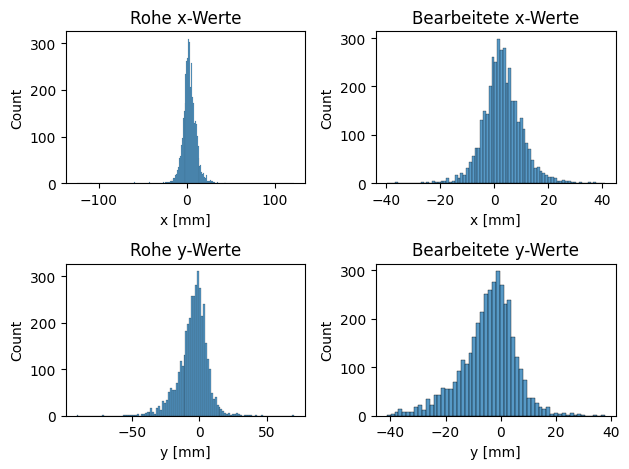

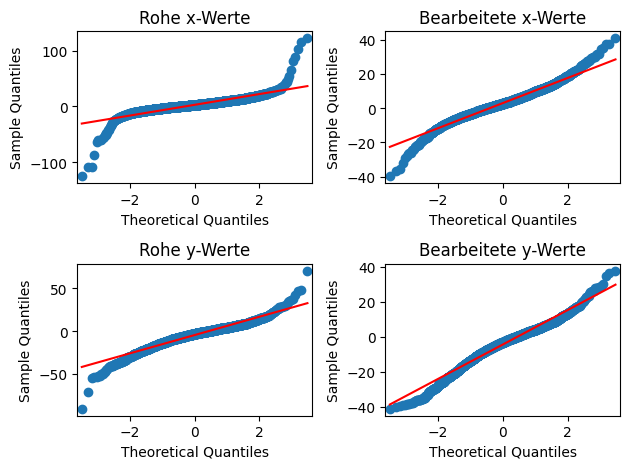

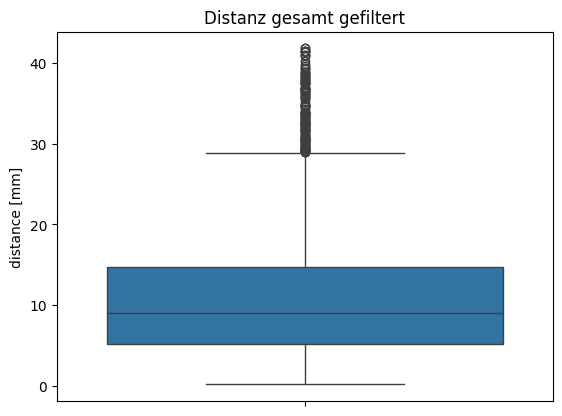

In [ ]:
plt.clf()
sb.histplot(merged_data["distance [mm]"])
plt.title("Distanz gesamt")
plt.show()

print("\n")
plt.clf()

sb.boxplot(data=merged_data["distance [mm]"])
plt.title("Distanz gesamt")
plt.show()

plt.clf()

out_complete_distance = remove_outliers(merged_data["distance [mm]"])
filtered_complete_distance = merged_data.where(out_complete_distance == False).dropna(subset=["x [mm]", "y [mm]"])

print("\n")

print("Anzahl Ausreißer gesamt: ", merged_data["x [mm]"].count() - filtered_complete_distance["x [mm]"].count())

print("\n")

filtered_vr = merged_data_vr.where(out_vr_distance == False).dropna()
filtered_real = merged_data_real.where(out_real_distance == False).dropna()

plot_data([merged_data["x [mm]"], filtered_complete_distance["x [mm]"],
           merged_data["y [mm]"], filtered_complete_distance["y [mm]"]])

plot_data([merged_data["x [mm]"], filtered_complete_distance["x [mm]"],
           merged_data["y [mm]"], filtered_complete_distance["y [mm]"]], histplot=False)

print("\n")

sb.boxplot(data=filtered_complete_distance["distance [mm]"])
plt.title("Distanz gesamt gefiltert")
plt.show()

In [ ]:
print("Shapiro-Test x ohne Distanz-Ausreißer: ", stats.shapiro(filtered_complete_distance["x [mm]"]))
print("Shapiro-Test y ohne Distanz-Ausreißer: ", stats.shapiro(filtered_complete_distance["y [mm]"]))
print("Levene-Test x-y ohne Distanz-Ausreißer: ", stats.levene(filtered_complete_distance["x [mm]"], filtered_complete_distance["y [mm]"]), "\n")

print("Schiefe und Kurtosis Distanz-Ausreißer herausgefiltert")
print("Schiefe x: ", stats.skew(filtered_complete_distance["x [mm]"]))
print("Kurtosis x: ", stats.kurtosis(filtered_complete_distance["x [mm]"]))
print("Schiefe y: ", stats.skew(filtered_complete_distance["y [mm]"]))
print("Kurtosis y: ", stats.kurtosis(filtered_complete_distance["y [mm]"]), "\n")

Shapiro-Test x ohne Distanz-Ausreißer:  ShapiroResult(statistic=0.9756050705909729, pvalue=1.8711850929766771e-25)
Shapiro-Test y ohne Distanz-Ausreißer:  ShapiroResult(statistic=0.9745036363601685, pvalue=5.585775542152673e-26)
Levene-Test x-y ohne Distanz-Ausreißer:  LeveneResult(statistic=228.39838748220612, pvalue=6.851941801208055e-51) 

Schiefe und Kurtosis Distanz-Ausreißer herausgefiltert
Schiefe x:  0.04129367966817863
Kurtosis x:  2.4249365620187753
Schiefe y:  -0.4900783355149375
Kurtosis y:  1.0910944372876479 



Transformationen

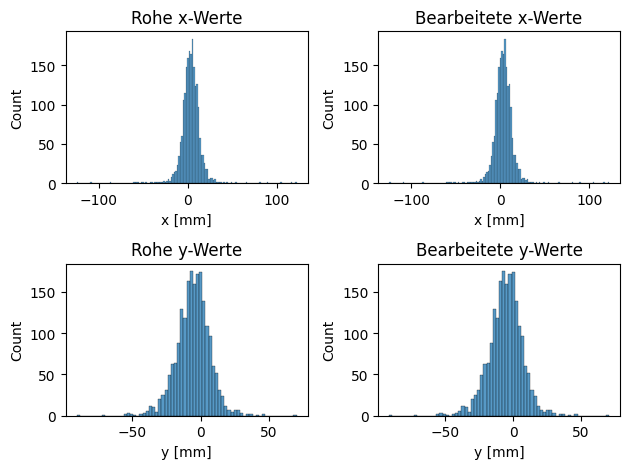

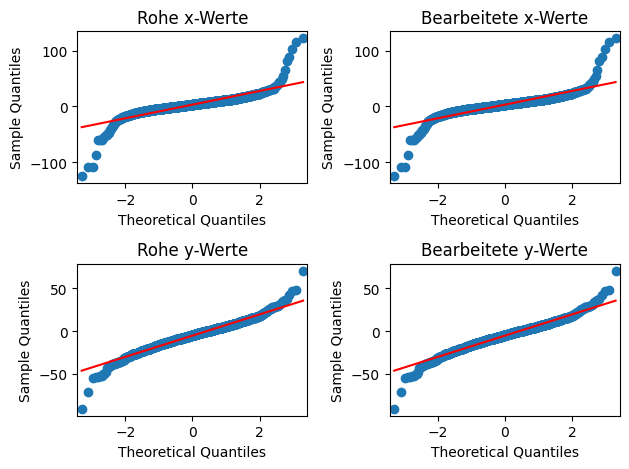

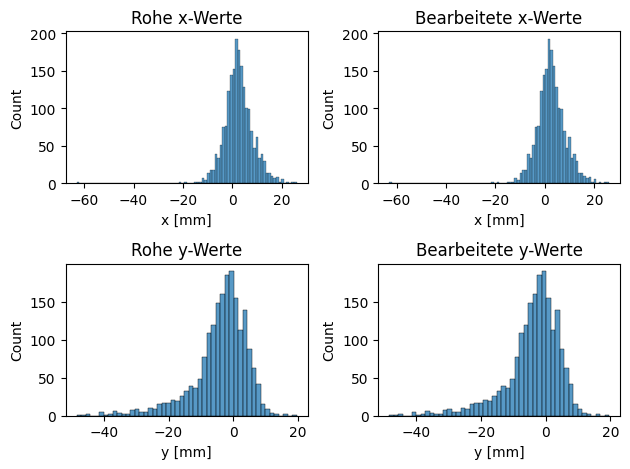

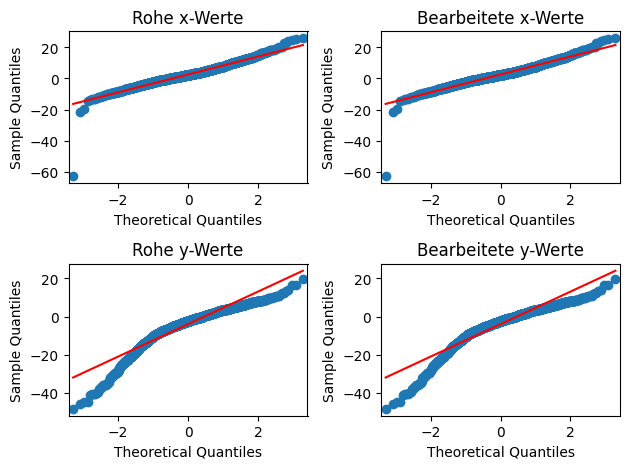

In [ ]:
def transformation(x):
    try:
      # Logarithmieren
      #return (np.log(abs(x)) if x != 0 else np.log(abs(x+0.0000000001)))

      # Wurzel ziehen
      #return np.sqrt(abs(x))

      # Kehrwert
      #return 1/x

      # Funktioniert alles nicht:
      return x

    except ZeroDivisionError:
      return 0

    # Theoretisch würde es auch "Power Transformer" oder generell ML-Methoden geben, um die Daten in eine Normalverteilung zu überführen

trans_vr_x = merged_data_vr["x [mm]"].apply(transformation)
trans_vr_y = merged_data_vr["y [mm]"].apply(transformation)

trans_real_x = merged_data_real["x [mm]"].apply(transformation)
trans_real_y = merged_data_real["y [mm]"].apply(transformation)

# VR
plot_data([merged_data_vr["x [mm]"], trans_vr_x,
           merged_data_vr["y [mm]"], trans_vr_y])

plot_data([merged_data_vr["x [mm]"], trans_vr_x,
           merged_data_vr["y [mm]"], trans_vr_y], histplot=False)

# Real
plot_data([merged_data_real["x [mm]"], trans_real_x,
           merged_data_real["y [mm]"], trans_real_y])

plot_data([merged_data_real["x [mm]"], trans_real_x,
           merged_data_real["y [mm]"], trans_real_y], histplot=False)


Tests

In [ ]:
print("Shapiro-Test VR x transformiert: ", stats.shapiro(trans_vr_x))
print("Shapiro-Test VR y transformiert: ", stats.shapiro(trans_vr_y))
print("Levene-Test VR transformiert: ", stats.levene(trans_vr_x, trans_vr_y), "\n")

print("Shapiro-Test Real x transformiert: ", stats.shapiro(trans_real_x))
print("Shapiro-Test Real y transformiert: ", stats.shapiro(trans_real_y))
print("Levene-Test Real transformiert: ", stats.levene(trans_real_x, trans_real_y), "\n")

print("Schiefe x VR: ", stats.skew(trans_vr_x))
print("Kurtosis x VR: ", stats.kurtosis(trans_vr_x))
print("Schiefe y VR: ", stats.skew(trans_vr_y))
print("Kurtosis y VR: ", stats.kurtosis(trans_vr_y), "\n")

print("Schiefe und Kurtosis transformiert")
print("Schiefe x real: ", stats.skew(trans_real_x))
print("Kurtosis x real: ", stats.kurtosis(trans_real_x))
print("Schiefe y real: ", stats.skew(trans_real_y))
print("Kurtosis y real: ", stats.kurtosis(trans_real_y), "\n")

Shapiro-Test VR x transformiert:  ShapiroResult(statistic=0.7831006050109863, pvalue=1.401298464324817e-45)
Shapiro-Test VR y transformiert:  ShapiroResult(statistic=0.9743993282318115, pvalue=1.2807442151360134e-18)
Levene-Test VR transformiert:  LeveneResult(statistic=41.74742087313378, pvalue=1.1609570089681099e-10) 

Shapiro-Test Real x transformiert:  ShapiroResult(statistic=0.9568185210227966, pvalue=1.1620201968387763e-23)
Shapiro-Test Real y transformiert:  ShapiroResult(statistic=0.900205135345459, pvalue=6.150693834618481e-34)
Levene-Test Real transformiert:  LeveneResult(statistic=113.00353777755511, pvalue=4.859417654823617e-26) 

Schiefe x VR:  -0.487443028371421
Kurtosis x VR:  27.75924521130848
Schiefe y VR:  -0.26900651968955097
Kurtosis y VR:  3.0591843575388236 

Schiefe und Kurtosis transformiert
Schiefe x real:  -0.4730502221610801
Kurtosis x real:  9.051013357705957
Schiefe y real:  -1.4727044482730371
Kurtosis y real:  3.368241003787177 



Tests für Daten der Mittelwerte

Schiefe x:  0.025918024034828964
Kurtosis x:  1.2435151368688206 

Schiefe y:  -1.32223188368685
Kurtosis y:  2.8323548180529263 

Shapiro-Test x:  ShapiroResult(statistic=0.9828246235847473, pvalue=0.00013713372754864395)
Shapiro-Test y:  ShapiroResult(statistic=0.9150303602218628, pvalue=5.098959787925607e-14)
Levene-Test x-y:  LeveneResult(statistic=37.52048482795066, pvalue=1.435245687238643e-09) 



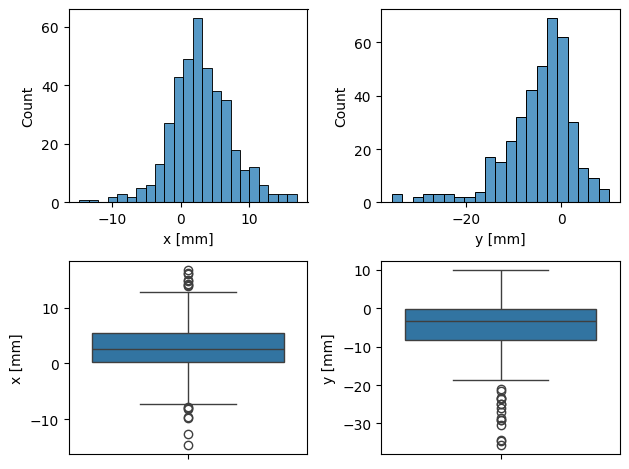

In [ ]:
merged_data_means = merged_data.groupby(["Participant", "mode", "Hammer", "series"], as_index=False).mean(numeric_only=True)

print("Schiefe x: ", stats.skew(merged_data_means["x [mm]"]))
print("Kurtosis x: ", stats.kurtosis(merged_data_means["x [mm]"]), "\n")

print("Schiefe y: ", stats.skew(merged_data_means["y [mm]"]))
print("Kurtosis y: ", stats.kurtosis(merged_data_means["y [mm]"]), "\n")

print("Shapiro-Test x: ", stats.shapiro(merged_data_means["x [mm]"]))
print("Shapiro-Test y: ", stats.shapiro(merged_data_means["y [mm]"]))
print("Levene-Test x-y: ", stats.levene(merged_data_means["x [mm]"], merged_data_means["y [mm]"]), "\n")


fig, axes = plt.subplots(2, 2)
sb.histplot(merged_data_means["x [mm]"], ax=axes[0, 0])
sb.histplot(merged_data_means["y [mm]"], ax=axes[0, 1])

sb.boxplot(merged_data_means["x [mm]"], ax=axes[1, 0])
sb.boxplot(merged_data_means["y [mm]"], ax=axes[1, 1])

plt.tight_layout()
plt.show()

Nur Mittelwerte der VP:

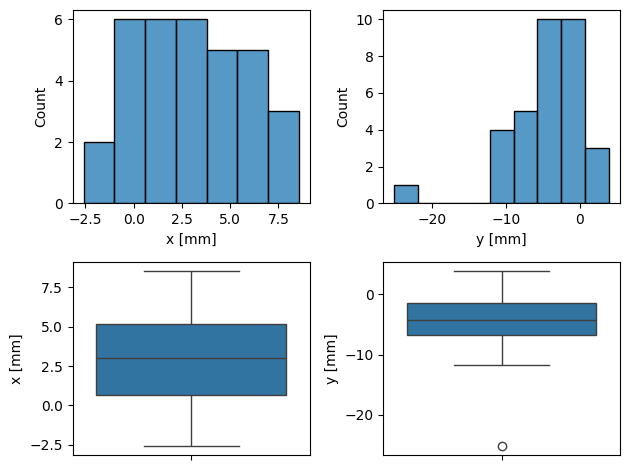



Schiefe x:  -0.010372989671160862
Kurtosis x:  -0.7973493721937044 

Schiefe y:  -1.7460767693796477
Kurtosis y:  5.057264485383673 

Shapiro-Test x:  ShapiroResult(statistic=0.9819696545600891, pvalue=0.8435857892036438)
Shapiro-Test y:  ShapiroResult(statistic=0.8672760725021362, pvalue=0.0008370664436370134)
Levene-Test x-y:  LeveneResult(statistic=2.878591853351886, pvalue=0.09462353663629032) 

Ausreißer herausgefiltert:


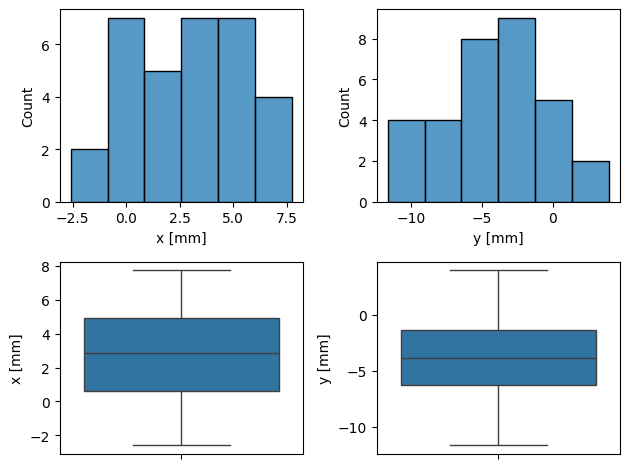



Schiefe x:  -0.08386717409545327
Kurtosis x:  -0.8363093379330437 

Schiefe y:  -0.20367785643648453
Kurtosis y:  -0.4194017590776431 

Shapiro-Test x:  ShapiroResult(statistic=0.9774844646453857, pvalue=0.7238379120826721)
Shapiro-Test y:  ShapiroResult(statistic=0.9789122343063354, pvalue=0.767391562461853)
Levene-Test x-y:  LeveneResult(statistic=2.650620678042729, pvalue=0.10858109638068981) 



In [ ]:
merged_data_only_participants = merged_data.groupby(["Participant"], as_index=False).mean(numeric_only=True)

fig, axes = plt.subplots(2, 2)
sb.histplot(merged_data_only_participants["x [mm]"], ax=axes[0, 0])
sb.histplot(merged_data_only_participants["y [mm]"], ax=axes[0, 1])

sb.boxplot(merged_data_only_participants["x [mm]"], ax=axes[1, 0])
sb.boxplot(merged_data_only_participants["y [mm]"], ax=axes[1, 1])

plt.tight_layout()
plt.show()
print("\n")

print("Schiefe x: ", stats.skew(merged_data_only_participants["x [mm]"]))
print("Kurtosis x: ", stats.kurtosis(merged_data_only_participants["x [mm]"]), "\n")

print("Schiefe y: ", stats.skew(merged_data_only_participants["y [mm]"]))
print("Kurtosis y: ", stats.kurtosis(merged_data_only_participants["y [mm]"]), "\n")

print("Shapiro-Test x: ", stats.shapiro(merged_data_only_participants["x [mm]"]))
print("Shapiro-Test y: ", stats.shapiro(merged_data_only_participants["y [mm]"]))
print("Levene-Test x-y: ", stats.levene(merged_data_only_participants["x [mm]"], merged_data_only_participants["y [mm]"]), "\n")


print("Ausreißer herausgefiltert:")

out_participants_distance = remove_outliers(merged_data_only_participants["distance [mm]"])
filtered_participants_distance = merged_data_only_participants.where(out_participants_distance == False).dropna(subset=["x [mm]", "y [mm]"])

fig, axes = plt.subplots(2, 2)
sb.histplot(filtered_participants_distance["x [mm]"], ax=axes[0, 0])
sb.histplot(filtered_participants_distance["y [mm]"], ax=axes[0, 1])

sb.boxplot(filtered_participants_distance["x [mm]"], ax=axes[1, 0])
sb.boxplot(filtered_participants_distance["y [mm]"], ax=axes[1, 1])

plt.tight_layout()
plt.show()
print("\n")

print("Schiefe x: ", stats.skew(filtered_participants_distance["x [mm]"]))
print("Kurtosis x: ", stats.kurtosis(filtered_participants_distance["x [mm]"]), "\n")

print("Schiefe y: ", stats.skew(filtered_participants_distance["y [mm]"]))
print("Kurtosis y: ", stats.kurtosis(filtered_participants_distance["y [mm]"]), "\n")

print("Shapiro-Test x: ", stats.shapiro(filtered_participants_distance["x [mm]"]))
print("Shapiro-Test y: ", stats.shapiro(filtered_participants_distance["y [mm]"]))
print("Levene-Test x-y: ", stats.levene(filtered_participants_distance["x [mm]"], filtered_participants_distance["y [mm]"]), "\n")

**Finale, besprochene Transformation**

Wir entfernen Ausreißer, welche außerhalb des äußersten Rings der Zielscheibe liegen (Distanz > 7cm)

Anzahl Ausreißer VR gesamt:  12
Anzahl Ausreißer Real gesamt:  0


VR-Daten gefiltert:


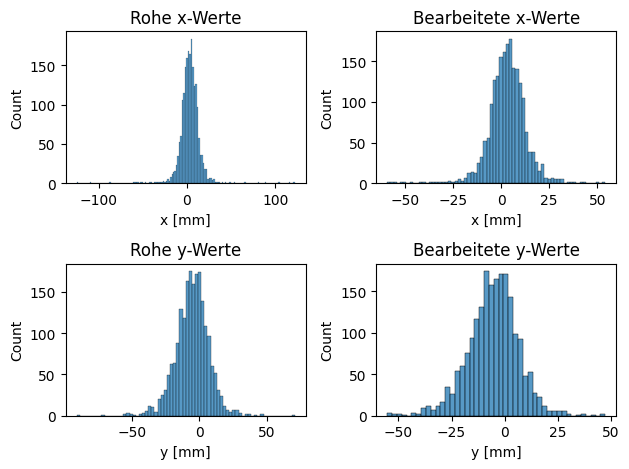

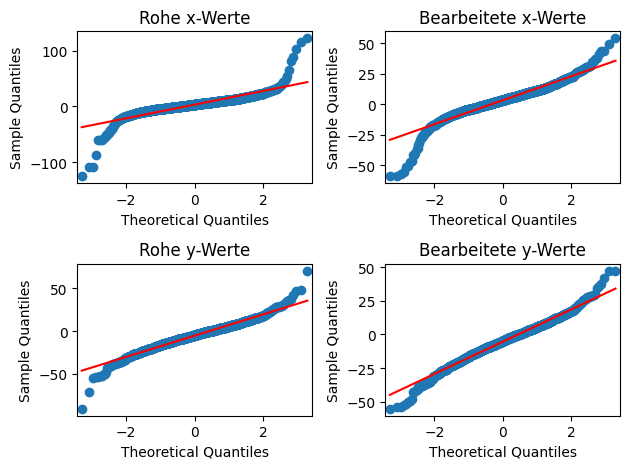

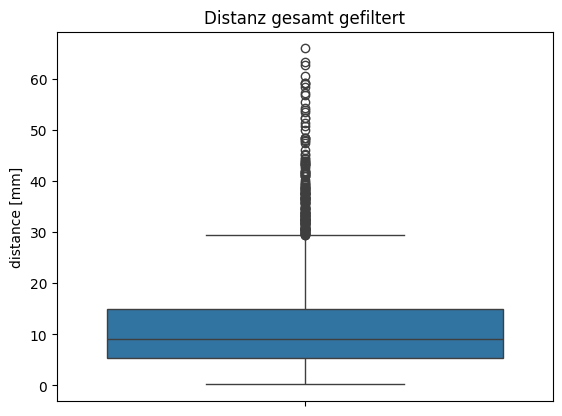



Schiefe x VR: -0.6924971792801117
Kurtosis x VR: 5.880679959886574 

Schiefe y VR: -0.2024889393992406
Kurtosis y VR: 1.3297614423355846 

Zum Vergleich:
Schiefe x Real: -0.4730502221610801
Kurtosis x Real: 9.051013357705957 

Schiefe y Real: -1.4727044482730371
Kurtosis y Real: 3.368241003787177


Schiefe und Kurtosis Gesamtdatensatz gefiltert
Schiefe x: -0.6584364380544885
Kurtosis x: 8.267107131169755 

Schiefe y: -0.6154577931647531
Kurtosis y: 2.14895257600502


Gesamter Datensatz gefiltert:


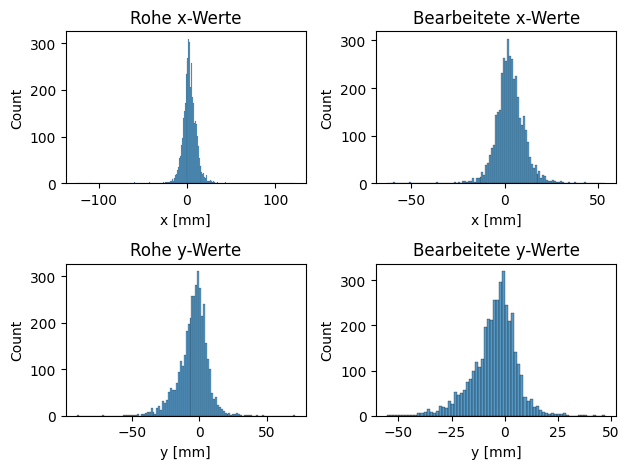

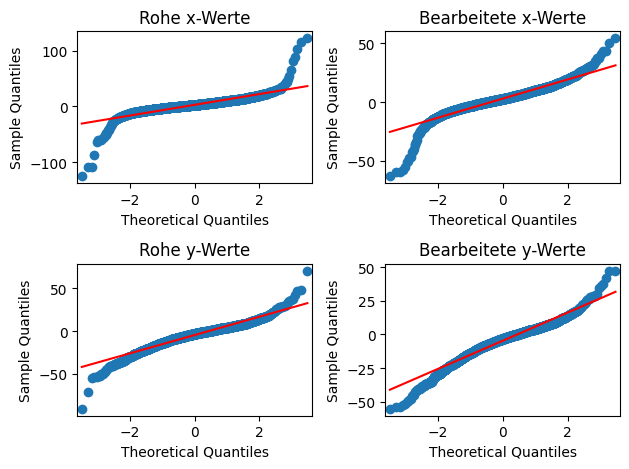





Auf VP heruntergebrochen:


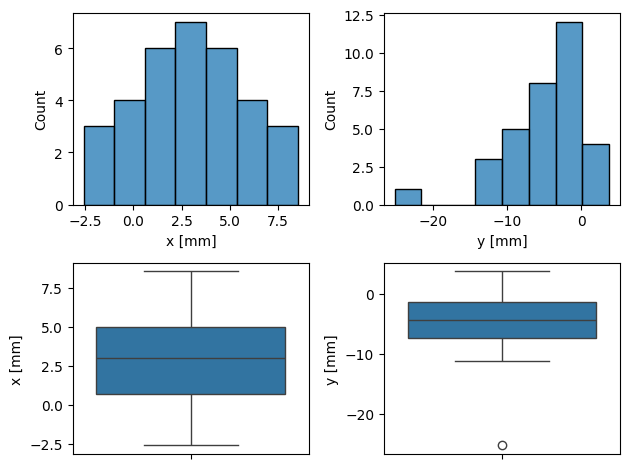



Schiefe x:  -0.05733025145529273
Kurtosis x:  -0.6410416648309005 

Schiefe y:  -1.7298309850062483
Kurtosis y:  4.943796469217507 

Shapiro-Test x:  ShapiroResult(statistic=0.9865882396697998, pvalue=0.9478978514671326)
Shapiro-Test y:  ShapiroResult(statistic=0.8682374358177185, pvalue=0.0008813459426164627)
Levene-Test x-y:  LeveneResult(statistic=3.533126509273264, pvalue=0.06470793690436696) 

               x [mm]     y [mm]  distance [mm]
Participant                                    
1.0          5.588248  -0.620292      14.271858
2.0          4.507856  -1.223650      10.802728
3.0          2.583737  -7.288058      11.073789
4.0          4.692614  -2.056147       8.932120
5.0          0.695246   3.768721       5.644593
6.0          7.742318  -6.173498      13.072798
7.0         -0.701840  -3.155798      14.455267
8.0          5.501711  -5.547914      10.909475
9.0          3.011426  -3.142846       8.559861
10.0         3.270520  -5.252969      10.983778
11.0         7.32243

In [ ]:
out_vr_distance_final = remove_outliers(merged_data_vr["distance [mm]"], based_on_z_values=False)
out_real_distance_final = remove_outliers(merged_data_real["distance [mm]"], based_on_z_values=False)

filtered_vr_distance_final = merged_data_vr.where(out_vr_distance_final == False).dropna(subset=["x [mm]", "y [mm]"])
filtered_real_distance_final = merged_data_real.where(out_real_distance_final == False).dropna(subset=["x [mm]", "y [mm]"])


print("Anzahl Ausreißer VR gesamt: ", merged_data_vr["distance [mm]"].count() - filtered_vr_distance_final["distance [mm]"].count())
print("Anzahl Ausreißer Real gesamt: ", merged_data_real["distance [mm]"].count() - filtered_real_distance_final["distance [mm]"].count())


print("\n")
print("VR-Daten gefiltert:")
plot_data([merged_data_vr["x [mm]"], filtered_vr_distance_final["x [mm]"],
           merged_data_vr["y [mm]"], filtered_vr_distance_final["y [mm]"]])

plot_data([merged_data_vr["x [mm]"], filtered_vr_distance_final["x [mm]"],
           merged_data_vr["y [mm]"], filtered_vr_distance_final["y [mm]"]], histplot=False)

print("\n")

final_filtered_data = pd.concat([filtered_vr_distance_final, filtered_real_distance_final]).reset_index()

sb.boxplot(data=final_filtered_data["distance [mm]"])
plt.title("Distanz gesamt gefiltert")
plt.show()

print("\n")

print("Schiefe x VR:", stats.skew(filtered_vr_distance_final["x [mm]"]))
print("Kurtosis x VR:", stats.kurtosis(filtered_vr_distance_final["x [mm]"]), "\n")

print("Schiefe y VR:", stats.skew(filtered_vr_distance_final["y [mm]"]))
print("Kurtosis y VR:", stats.kurtosis(filtered_vr_distance_final["y [mm]"]), "\n")

print("Zum Vergleich:")
print("Schiefe x Real:", stats.skew(filtered_real_distance_final["x [mm]"]))
print("Kurtosis x Real:", stats.kurtosis(filtered_real_distance_final["x [mm]"]), "\n")

print("Schiefe y Real:", stats.skew(filtered_real_distance_final["y [mm]"]))
print("Kurtosis y Real:", stats.kurtosis(filtered_real_distance_final["y [mm]"]))
print("\n")

print("Schiefe und Kurtosis Gesamtdatensatz gefiltert")
print("Schiefe x:", stats.skew(final_filtered_data["x [mm]"]))
print("Kurtosis x:", stats.kurtosis(final_filtered_data["x [mm]"]), "\n")

print("Schiefe y:", stats.skew(final_filtered_data["y [mm]"]))
print("Kurtosis y:", stats.kurtosis(final_filtered_data["y [mm]"]))
print("\n")

print("Gesamter Datensatz gefiltert:")
plot_data([merged_data["x [mm]"], final_filtered_data["x [mm]"],
           merged_data["y [mm]"], final_filtered_data["y [mm]"]])

plot_data([merged_data["x [mm]"], final_filtered_data["x [mm]"],
           merged_data["y [mm]"], final_filtered_data["y [mm]"]], histplot=False)

print("\n")

print("Auf VP heruntergebrochen:")
final_filtered_data_group_vp = final_filtered_data.groupby(["Participant"], as_index=False).mean(numeric_only=True)

fig, axes = plt.subplots(2, 2)
sb.histplot(final_filtered_data_group_vp["x [mm]"], ax=axes[0, 0])
sb.histplot(final_filtered_data_group_vp["y [mm]"], ax=axes[0, 1])

sb.boxplot(final_filtered_data_group_vp["x [mm]"], ax=axes[1, 0])
sb.boxplot(final_filtered_data_group_vp["y [mm]"], ax=axes[1, 1])

plt.tight_layout()
plt.show()
print("\n")

print("Schiefe x: ", stats.skew(final_filtered_data_group_vp["x [mm]"]))
print("Kurtosis x: ", stats.kurtosis(final_filtered_data_group_vp["x [mm]"]), "\n")

print("Schiefe y: ", stats.skew(final_filtered_data_group_vp["y [mm]"]))
print("Kurtosis y: ", stats.kurtosis(final_filtered_data_group_vp["y [mm]"]), "\n")

print("Shapiro-Test x: ", stats.shapiro(final_filtered_data_group_vp["x [mm]"]))
print("Shapiro-Test y: ", stats.shapiro(final_filtered_data_group_vp["y [mm]"]))
print("Levene-Test x-y: ", stats.levene(final_filtered_data_group_vp["x [mm]"], final_filtered_data_group_vp["y [mm]"]), "\n")

print(final_filtered_data_group_vp.set_index("Participant")[["x [mm]", "y [mm]", "distance [mm]"]])

-> VP 22 verursacht hier krasse Ausreißer, da sie stark daneben geschlagen hat

**Multiple Imputationen der fehlenden Werte durch den jeweiligen Median und Standardabweichung pro VP/Hammergewicht/Durchgang**

-> Wenn ein VP/Gewicht/Durchgang z.B. 6 Treffer hat und einer 5, wird der mit 5 durch Bootstrapping auf 6 Treffer imputiert

In [ ]:
filtered_vr_distance_final["mode"] = "VR"
filtered_real_distance_final["mode"] = "Real"

filtered_vr_distance_final["mode"] = "VR"
filtered_real_distance_final["mode"] = "Real"

filtered_vr_distance_final["Hammer"] = filtered_vr_distance_final["position"].apply(map_weight)
filtered_real_distance_final["Hammer"] = filtered_real_distance_final["position"].apply(map_weight)

imputed_vr = filtered_vr_distance_final.copy()
imputed_real = filtered_real_distance_final.copy()

del imputed_vr["left/righthanded"], imputed_vr["hammer"]

# Multiple Imputationen der Werte pro VP durch Bootstrapping
for vp, data in filtered_real_distance_final.groupby(["Participant", "Hammer"]):

  if data.loc[data["series"] == 1].shape[0] > data.loc[data["series"] == 2].shape[0]:
    difference = data.loc[data["series"] == 1].shape[0] - data.loc[data["series"] == 2].shape[0]

    while difference > 0:
      new_x = np.random.normal(data.loc[data["series"] == 2]["x [mm]"].median(), data.loc[data["series"] == 2]["x [mm]"].std())
      new_y = np.random.normal(data.loc[data["series"] == 2]["y [mm]"].median(), data.loc[data["series"] == 2]["y [mm]"].std())

      imputed_real.loc[len(imputed_real.index)] = [vp[0], 0.0, data["position"].mode().values[0], 2.0, new_x, new_y, 0.0, "Real", data["Hammer"].mode().values[0]]

      difference -= 1

  elif data.loc[data["series"] == 1].shape[0] < data.loc[data["series"] == 2].shape[0]:
    difference = data.loc[data["series"] == 2].shape[0] - data.loc[data["series"] == 1].shape[0]

    while difference > 0:
      new_x = np.random.normal(data.loc[data["series"] == 1]["x [mm]"].median(), data.loc[data["series"] == 1]["x [mm]"].std())
      new_y = np.random.normal(data.loc[data["series"] == 1]["y [mm]"].median(), data.loc[data["series"] == 1]["y [mm]"].std())

      imputed_real.loc[len(imputed_real.index)] = [vp[0], 0.0, data["position"].mode().values[0], 1.0, new_x, new_y, 0.0, "Real", data["Hammer"].mode().values[0]]

      difference -= 1

  else:
    continue

for vp, data in filtered_vr_distance_final.groupby(["Participant", "Hammer"]):

  if data.loc[data["series"] == 1].shape[0] > data.loc[data["series"] == 2].shape[0]:
    difference = data.loc[data["series"] == 1].shape[0] - data.loc[data["series"] == 2].shape[0]

    while difference > 0:
      new_x = np.random.normal(data.loc[data["series"] == 2]["x [mm]"].median(), data.loc[data["series"] == 2]["x [mm]"].std())
      new_y = np.random.normal(data.loc[data["series"] == 2]["y [mm]"].median(), data.loc[data["series"] == 2]["y [mm]"].std())
      imputed_vr.loc[len(imputed_vr.index)] = [vp[0], 0.0, data["position"].mode().values[0], 2.0, new_x, new_y, 0.0, "VR", data["Hammer"].mode().values[0]]

      difference -= 1

  elif data.loc[data["series"] == 1].shape[0] < data.loc[data["series"] == 2].shape[0]:
    difference = data.loc[data["series"] == 2].shape[0] - data.loc[data["series"] == 1].shape[0]

    while difference > 0:
      new_x = np.random.normal(data.loc[data["series"] == 1]["x [mm]"].median(), data.loc[data["series"] == 1]["x [mm]"].std())
      new_y = np.random.normal(data.loc[data["series"] == 1]["y [mm]"].median(), data.loc[data["series"] == 1]["y [mm]"].std())

      imputed_vr.loc[len(imputed_vr.index)] = [vp[0], 0.0, data["position"].mode().values[0], 1.0, new_x, new_y, 0.0, "VR", data["Hammer"].mode().values[0]]

      difference -= 1

  else:
    continue

df_final = pd.concat([imputed_vr, imputed_real])

Schnell noch ein paar Deskriptivstatistiken dazu:

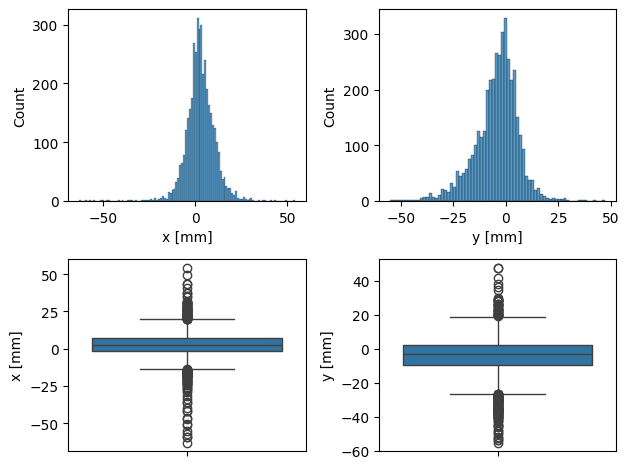



Schiefe x:  -0.6357549965120228
Kurtosis x:  8.10301074498972 

Schiefe y:  -0.6227600377466384
Kurtosis y:  2.16715537454509 

Shapiro-Test x:  ShapiroResult(statistic=0.9249249696731567, pvalue=2.9874281960940775e-41)
Shapiro-Test y:  ShapiroResult(statistic=0.9609003663063049, pvalue=6.389254370342217e-32)
Levene-Test x-y:  LeveneResult(statistic=193.17756813996687, pvalue=1.993905766650051e-43) 



In [ ]:
fig, axes = plt.subplots(2, 2)
sb.histplot(df_final["x [mm]"], ax=axes[0, 0])
sb.histplot(df_final["y [mm]"], ax=axes[0, 1])

sb.boxplot(df_final["x [mm]"], ax=axes[1, 0])
sb.boxplot(df_final["y [mm]"], ax=axes[1, 1])

plt.tight_layout()
plt.show()
print("\n")

print("Schiefe x: ", stats.skew(df_final["x [mm]"]))
print("Kurtosis x: ", stats.kurtosis(df_final["x [mm]"]), "\n")

print("Schiefe y: ", stats.skew(df_final["y [mm]"]))
print("Kurtosis y: ", stats.kurtosis(df_final["y [mm]"]), "\n")

print("Shapiro-Test x: ", stats.shapiro(df_final["x [mm]"]))
print("Shapiro-Test y: ", stats.shapiro(df_final["y [mm]"]))
print("Levene-Test x-y: ", stats.levene(df_final["x [mm]"], df_final["y [mm]"]), "\n")

In CSV-Datei abspeichern, damit wir später immer wieder drauf zurückgreifen können:

In [ ]:
#from google.colab import files
#df_final.to_csv('hv_final_data.csv')
#files.download('hv_final_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Ab hier kann wieder ausgeführt werden

**5. Inferenzstatistische Tests**

Gruppenvergleiche:

In [ ]:
df_final = pd.read_csv('/content/HammerProjekt/Ergebnisse/hv_final_data.csv')

df_final.rename(columns={'x [mm]': 'x'}, inplace = True)
df_final.rename(columns={'y [mm]': 'y'}, inplace = True)
df_final.rename(columns={'distance [mm]': 'distance'}, inplace = True)

df_final["position"] = df_final["position"].astype("object")
df_final["series"] = df_final["series"].astype("object")
df_final["Participant"] = df_final["Participant"].astype("object")

manova = MANOVA.from_formula("mode + series + mode:series + mode:Hammer ~ x + y", data=df_final)

print(manova.mv_test())

                                 Multivariate linear model
                                                                                            
--------------------------------------------------------------------------------------------
       Intercept               Value         Num DF   Den DF          F Value         Pr > F
--------------------------------------------------------------------------------------------
          Wilks' lambda               0.0000 8.0000 4096.0000 419244183493398400.0000 0.0000
         Pillai's trace               1.0000 8.0000 4096.0000 419244183493398400.0000 0.0000
 Hotelling-Lawley trace 818836295885543.7500 8.0000 4096.0000 419244183493398400.0000 0.0000
    Roy's greatest root 818836295885543.7500 8.0000 4096.0000 419244183493398400.0000 0.0000
--------------------------------------------------------------------------------------------
                                                                                            
-----------

-> hoch signifikantes Ergebnis aber quasi kaum Effekt (siehe Wilk's lambda, je kleiner desto größerer Effekt). Daher zusätzlich Mittelwertsvergleich:

In [ ]:
df_final_means = df_final.groupby(["mode", "Hammer", "series"], as_index=False).mean(numeric_only=True)

manova_means = MANOVA.from_formula("mode + series + mode:series + mode:Hammer ~ x + y", data=df_final_means)

print(manova_means.mv_test())

                             Multivariate linear model
                                                                                   
-----------------------------------------------------------------------------------
       Intercept               Value        Num DF Den DF      F Value       Pr > F
-----------------------------------------------------------------------------------
          Wilks' lambda              0.0000 8.0000 2.0000 7171336986258.5020 0.0000
         Pillai's trace              1.0000 8.0000 2.0000 7171336986258.5020 0.0000
 Hotelling-Lawley trace 28685347945034.0078 8.0000 1.0000 3585668493129.2510 0.0000
    Roy's greatest root 28685347945034.0078 8.0000 2.0000 7171336986258.5020 0.0000
-----------------------------------------------------------------------------------
                                                                                   
---------------------------------------------------------------------------------------
                 

**Post-hoc Analysen:**

Da wir von ungleichen Varianzen ausgehen, nehmen wir den Games-Howell-Test für Post-hoc Analysen (siehe Field (2018))
-> nur für unabhängige Stichproben! Für abhängige Stichproben nehmen wir Wilcoxon-Tests (aus Ermangelung an Alternativen)

In [ ]:
print("_______________________Hammer:_______________________", "\n")
#print(df_final.groupby("Hammer")["x"].count())

light_posthoc = df_final.loc[df_final["Hammer"] == "leicht"]
medium_posthoc = df_final.loc[df_final["Hammer"] == "mittel"]
heavy_posthoc = df_final.loc[df_final["Hammer"] == "schwer"]

print("Leichter Hammer:")
print("x: ")
print(pairwise_gameshowell(light_posthoc, dv='x', between="mode"), "\n")
print("y: ")
print(pairwise_gameshowell(light_posthoc, dv='y', between="mode"), "\n\n")

print("Mittlerer Hammer:")
print("x: ")
print(pairwise_gameshowell(medium_posthoc, dv='x', between="mode"), "\n")
print("y: ")
print(pairwise_gameshowell(medium_posthoc, dv='y', between="mode"), "\n")

print("Schwerer Hammer:")
print("x: ")
print(pairwise_gameshowell(heavy_posthoc, dv='x', between="mode"), "\n")
print("y: ")
print(pairwise_gameshowell(heavy_posthoc, dv='y', between="mode"), "\n\n")

posthoc_manova = MANOVA.from_formula("Hammer:mode ~ x + y", data=df_final)
print(posthoc_manova.mv_test(skip_intercept_test=True))


print("_______________________Modus:_______________________")
print("x: ")
print(pairwise_gameshowell(df_final, dv='x', between="mode"), "\n")
print("y: ")
print(pairwise_gameshowell(df_final, dv='y', between="mode"), "\n\n")


print("_______________________Durchgang:_______________________")
vr_posthoc = df_final.loc[df_final["mode"] == "VR"]
real_posthoc = df_final.loc[df_final["mode"] == "Real"]

print("VR:")
print("x: ")
print(posthoc_wilcoxon(vr_posthoc, val_col="x", group_col="series"), "\n")
print("y: ")
print(posthoc_wilcoxon(vr_posthoc, val_col='y', group_col="series"), "\n\n")

print("Real:")
print("x: ")
print(posthoc_wilcoxon(real_posthoc, val_col="x", group_col="series"), "\n")
print("y: ")
print(posthoc_wilcoxon(real_posthoc, val_col='y', group_col="series"), "\n")

posthoc_manova = MANOVA.from_formula("series:mode ~ x + y", data=df_final)
print(posthoc_manova.mv_test(skip_intercept_test=True))


print("Mittelwerte VR")
print(vr_posthoc.groupby("series", as_index=False)[["x","y"]].mean(numeric_only=True), "\n")
print("Mittelwerte Real")
print(real_posthoc.groupby("series", as_index=False)[["x","y"]].mean(numeric_only=True))

_______________________Hammer:_______________________ 

Leichter Hammer:
x: 
      A   B   mean(A)   mean(B)      diff        se         T           df  \
0  Real  VR  2.064906  2.963247 -0.898341  0.417437 -2.152038  1163.997341   

     pval    hedges  
0  0.0316 -0.117489   

y: 
      A   B   mean(A)   mean(B)      diff        se         T           df  \
0  Real  VR -2.719147 -6.502278  3.783132  0.554629  6.821009  1108.204552   

           pval    hedges  
0  1.457212e-11  0.372076   


Mittlerer Hammer:
x: 
      A   B   mean(A)   mean(B)      diff       se         T           df  \
0  Real  VR  2.662414  3.016041 -0.353627  0.40735 -0.868115  1186.052162   

       pval    hedges  
0  0.385507 -0.046418   

y: 
      A   B   mean(A)   mean(B)      diff        se         T           df  \
0  Real  VR -4.613674 -7.432211  2.818537  0.566017  4.979601  1312.521011   

           pval    hedges  
0  7.219014e-07  0.266797   

Schwerer Hammer:
x: 
      A   B  mean(A)   mean(B)   

Und jetzt nochmal Post-hoc Vergleiche von Mittelwerten:

In [ ]:
print("_______________________Hammer:_______________________", "\n")
#print(df_final.groupby("Hammer")["x"].count())

light_mean_posthoc = df_final_means.loc[df_final_means["Hammer"] == "leicht"]
medium_mean_posthoc = df_final_means.loc[df_final_means["Hammer"] == "mittel"]
heavy_mean_posthoc = df_final_means.loc[df_final_means["Hammer"] == "schwer"]

print("Leichter Hammer:")
print("x: ")
print(pairwise_gameshowell(light_mean_posthoc, dv='x', between="mode"), "\n")
print("y: ")
print(pairwise_gameshowell(light_mean_posthoc, dv='y', between="mode"), "\n")

print("Mittlerer Hammer:")
print("x: ")
print(pairwise_gameshowell(medium_mean_posthoc, dv='x', between="mode"), "\n")
print("y: ")
print(pairwise_gameshowell(medium_mean_posthoc, dv='y', between="mode"), "\n\n")

print("Schwerer Hammer:")
print("x: ")
print(pairwise_gameshowell(heavy_mean_posthoc, dv='x', between="mode"), "\n")
print("y: ")
print(pairwise_gameshowell(heavy_mean_posthoc, dv='y', between="mode"), "\n\n")

posthoc_manova = MANOVA.from_formula("Hammer:mode ~ x + y", data=df_final)
print(posthoc_manova.mv_test(skip_intercept_test=True))



print("Modus:")
print("x: ")
print(pairwise_gameshowell(df_final_means, dv='x', between="mode"), "\n")
print("y: ")
print(pairwise_gameshowell(df_final_means, dv='y', between="mode"), "\n\n")


print("_______________________Durchgang:_______________________")

vr_mean_posthoc = df_final.loc[df_final["mode"] == "VR"].groupby(["Participant", "series"], as_index=False).mean(numeric_only=True)
real_mean_posthoc = df_final.loc[df_final["mode"] == "Real"].groupby(["Participant", "series"], as_index=False).mean(numeric_only=True)

print("VR:")
print("x: ")
print(posthoc_wilcoxon(vr_mean_posthoc, val_col="x", group_col="series"), "\n")
print("y: ")
print(posthoc_wilcoxon(vr_mean_posthoc, val_col='y', group_col="series"), "\n\n")

print("Real:")
print("x: ")
print(posthoc_wilcoxon(real_mean_posthoc, val_col="x", group_col="series"), "\n")
print("y: ")
print(posthoc_wilcoxon(real_mean_posthoc, val_col='y', group_col="series"), "\n\n")

posthoc_manova = MANOVA.from_formula("series:mode ~ x + y", data=df_final)
print(posthoc_manova.mv_test(skip_intercept_test=True))

_______________________Hammer:_______________________ 

Leichter Hammer:
x: 
      A   B   mean(A)   mean(B)      diff        se         T        df  \
0  Real  VR  2.064906  2.963247 -0.898341  0.724307 -1.240276  1.803322   

       pval    hedges  
0  0.352082 -0.708729   

y: 
      A   B   mean(A)   mean(B)      diff        se         T        df  \
0  Real  VR -2.719147 -6.502278  3.783132  1.399322  2.703547  1.002813   

       pval    hedges  
0  0.224976  1.544884   

Mittlerer Hammer:
x: 
      A   B   mean(A)   mean(B)      diff        se         T        df  \
0  Real  VR  2.662414  3.016041 -0.353627  0.371887 -0.950897  1.116515   

       pval   hedges  
0  0.502369 -0.54337   

y: 
      A   B   mean(A)   mean(B)      diff        se         T        df  \
0  Real  VR -4.613674 -7.432211  2.818537  1.247686  2.259012  1.588972   

       pval    hedges  
0  0.184266  1.290864   


Schwerer Hammer:
x: 
      A   B  mean(A)   mean(B)     diff        se         T        df

**4. Vergleiche innerhalb der Person**

In [ ]:
significant_x = 0
significant_y = 0
significant_light_hammer_x = 0
significant_light_hammer_y = 0
significant_medium_hammer_x = 0
significant_medium_hammer_y = 0
significant_heavy_hammer_x = 0
significant_heavy_hammer_y = 0
significant_vr_series_x = 0
significant_real_series_x = 0
significant_vr_series_y = 0
significant_real_series_y = 0

for index, data, in df_final[["Participant", "Hammer", "mode", "series", "x", "y"]].groupby("Participant", as_index=False):
    print("Versuchsperson {}: ".format(int(index)))

    data_vp_final = df_final[["Participant", "Hammer", "mode", "series", "x", "y"]].loc[df_final["Participant"] == index].groupby(["mode", "Hammer", "series"], as_index=False, group_keys=True)
    data_vp_final = data_vp_final.apply(lambda x: x)

    manova_vp = MANOVA.from_formula("mode + series + mode:series + mode:Hammer ~ x + y", data=data).mv_test(skip_intercept_test=True)

    x = pd.DataFrame((manova_vp.results['x']['stat']))
    y = pd.DataFrame((manova_vp.results['y']['stat']))


    results_dict = {"x": x, "y": y}

    for var in results_dict:
      if results_dict[var]["Pr > F"][0] < 0.05:
        print("Variable", var, "signifikant, p =", results_dict[var]["Pr > F"][0])

        light_vp_posthoc = data_vp_final.loc[data_vp_final["Hammer"] == "leicht"]
        medium_vp_posthoc = data_vp_final.loc[data_vp_final["Hammer"] == "mittel"]
        heavy_vp_posthoc = data_vp_final.loc[data_vp_final["Hammer"] == "schwer"]

        vr_vp_posthoc = data_vp_final.loc[data_vp_final["mode"] == "VR"]
        real_vp_posthoc = data_vp_final.loc[data_vp_final["mode"] == "Real"]


        # Falls genaue Ergebnisse pro VP gewünscht, bitte die Kommentare in diesem Block entfernen (die ''' vor und hinter den Ausdrücken entfernen)
        # (der Ausdruck wird sonst ewig lang)
        '''
        print("Posthoc: ")
        print("Leichter Hammer:")
        print(var, ":")
        print(pairwise_gameshowell(light_vp_posthoc, dv=var, between="mode"), "\n")

        print("Mittlerer Hammer:")
        print(var, ":")
        print(pairwise_gameshowell(medium_vp_posthoc, dv=var, between="mode"), "\n")

        print("Schwerer Hammer:")
        print(var, ":")
        print(pairwise_gameshowell(heavy_vp_posthoc, dv=var, between="mode"), "\n")


        posthoc_vp_manova = MANOVA.from_formula("Hammer:mode ~ x + y + distance", data=data_vp_final)
        print(posthoc_vp_manova.mv_test(skip_intercept_test=True))

        print(pairwise_gameshowell(data_vp_final, dv=var, between="mode"), "\n")

        print("VR:")
        print(var, ":")
        print(posthoc_wilcoxon(vr_vp_posthoc, val_col=var, group_col="series"), "\n")

        print("Real:")
        print(var, ":")
        print(posthoc_wilcoxon(real_vp_posthoc, val_col=vr, group_col="series"), "\n")

        posthoc_manova = MANOVA.from_formula("series:mode ~ x + y + distance", data=df_final)
        print(posthoc_manova.mv_test(skip_intercept_test=True))
        '''

        if var == "x":
          significant_x += 1
          significant_light_hammer_x += 1 if pairwise_gameshowell(light_vp_posthoc, dv=var, between="mode").pval[0] < 0.05 else 0
          significant_medium_hammer_x += 1 if pairwise_gameshowell(medium_vp_posthoc, dv=var, between="mode").pval[0] < 0.05 else 0
          significant_heavy_hammer_x += 1 if pairwise_gameshowell(heavy_vp_posthoc, dv=var, between="mode").pval[0] < 0.05 else 0
          significant_vr_series_x += 1 if posthoc_wilcoxon(vr_vp_posthoc, val_col=var, group_col="series").iloc[0, 1] < 0.05 else 0
          significant_real_series_x += 1 if posthoc_wilcoxon(real_vp_posthoc, val_col=var, group_col="series").iloc[0, 1] < 0.05 else 0
        elif var == "y":
          significant_y += 1
          significant_light_hammer_y += 1 if pairwise_gameshowell(light_vp_posthoc, dv=var, between="mode").pval[0] < 0.05 else 0
          significant_medium_hammer_y += 1 if pairwise_gameshowell(medium_vp_posthoc, dv=var, between="mode").pval[0] < 0.05 else 0
          significant_heavy_hammer_y += 1 if pairwise_gameshowell(heavy_vp_posthoc, dv=var, between="mode").pval[0] < 0.05 else 0
          significant_vr_series_y  += 1 if posthoc_wilcoxon(vr_vp_posthoc, val_col=var, group_col="series").iloc[0, 1] < 0.05 else 0
          significant_real_series_y += 1 if posthoc_wilcoxon(real_vp_posthoc, val_col=var, group_col="series").iloc[0, 1] < 0.05 else 0

    print("\n\n")

print("Anzahl signifikanter x-Werte:", significant_x)
print("Anzahl signifikanter y-Werte:", significant_y, "\n\n")
print("Anzahl signifikanter Hammerwerte:")
print("Leicht")
print("x:", significant_light_hammer_x)
print("y:", significant_light_hammer_y, "\n")
print("Mittel")
print("x:", significant_medium_hammer_x)
print("y:", significant_medium_hammer_y, "\n")
print("Schwer")
print("x:", significant_heavy_hammer_x)
print("y:", significant_heavy_hammer_y, "\n\n")

print("Anzahl signifikanter Werte je Präsentationsmodus:")
print("VR:")
print("x:", significant_vr_series_x)
print("y:", significant_vr_series_y, "\n")
print("Real:")
print("x:", significant_real_series_x)
print("y:", significant_real_series_y)

Versuchsperson 1: 
Variable x signifikant, p = 0.0005359963988544964
Variable y signifikant, p = 3.5657042117991067e-11



Versuchsperson 2: 
Variable x signifikant, p = 0.013808202294901123
Variable y signifikant, p = 0.002432303280957589



Versuchsperson 3: 
Variable x signifikant, p = 0.038883467547351606



Versuchsperson 4: 
Variable x signifikant, p = 5.671906012662344e-09
Variable y signifikant, p = 0.00027951938060624096



Versuchsperson 5: 
Variable x signifikant, p = 0.00897439045923061
Variable y signifikant, p = 0.0020906339001401375



Versuchsperson 6: 
Variable x signifikant, p = 0.013092699358232606
Variable y signifikant, p = 0.007256266545033132



Versuchsperson 7: 
Variable x signifikant, p = 0.00021866220312627646
Variable y signifikant, p = 0.014590937399256019



Versuchsperson 8: 
Variable y signifikant, p = 0.00015942380095984455



Versuchsperson 9: 
Variable x signifikant, p = 0.01581179621968379
Variable y signifikant, p = 0.0007368751022145007



Versuchs